In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.inspection import permutation_importance
from sklearn import set_config
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN
)
from imblearn.under_sampling import RandomUnderSampler
from category_encoders import CatBoostEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.integration import CatBoostPruningCallback
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
import joblib

# Настройки отображения
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')
set_config(enable_metadata_routing=True)

In [2]:
sessions = pd.read_csv('./ga_sessions.csv',low_memory=False)
hits = pd.read_csv('./ga_hits.csv',low_memory=False)

#### Общий анализ данных

In [4]:
sessions.head(2)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow


In [5]:
hits.head(2)

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN


In [6]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [7]:
hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [8]:
sessions.isna().sum()

session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       97
utm_medium                        0
utm_campaign                 219603
utm_adcontent                335615
utm_keyword                 1082061
device_category                   0
device_os                   1070138
device_brand                 367178
device_model                1843704
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64

In [9]:
hits.isna().sum()

session_id               0
hit_date                 0
hit_time           9160322
hit_number               0
hit_type                 0
hit_referer        6274804
hit_page_path            0
event_category           0
event_action             0
event_label        3760184
event_value       15726470
dtype: int64

In [10]:
sessions.describe()

,visit_number
count,1.860042e+06
mean,2.712804e+00
std,1.182907e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,5.640000e+02


In [11]:
hits.describe()

,hit_time,hit_number,event_value
count,6.566148e+06,1.572647e+07,0.0
mean,2.091050e+05,2.356715e+01,NaN
std,4.032110e+05,2.887713e+01,NaN
min,0.000000e+00,1.000000e+00,NaN
25%,2.412000e+04,7.000000e+00,NaN
50%,8.994100e+04,1.500000e+01,NaN
75%,2.195352e+05,2.900000e+01,NaN
max,1.315688e+07,5.000000e+02,NaN


Датасет содержит 1,860,042 сессий с 18 признаками. Основные наблюдения:

Клиенты: 1,391,719 уникальных client_id при 1,860,042 сессита

Даты: 226 уникальных дат → данные покрывают примерно 7.5 месяцев

Пропуски:

utm_keyword пропущен в 58% случаев

utm_adcontent пропущен в 18% случаев

device_os пропущен в 57.5% случаев

device_model пропущен в 99% случаев (вероятно, неинформативен)
ностью пропущен (можно удалить)

Датасет содержит 15,726,470 действий (хитов) с 11 признаками:

Сессии: 1,734,610 уникальных session_id

Типы хитов: только 1 тип (hit_type)

Пропуски:

hit_time пропущен в ~60% случаев

hit_referer пропущен в ~40% случаев

event_label пропущен в ~25%5 случаев

event_value полностью пропущен (можно удалить)

#### Анализ важных признаков

Топ-10 источников трафика составляют 90.86% всех сессий

Детальное распределение топ-10 источников:
utm_source
ZpYIoDJMcFzVoPFsHGJL    31.091780
fDLlAcSmythWSCVMvqvL    16.160424
kjsLglQLzykiRbcDiGcD    14.320531
MvfHsxITijuriZxsqZqt    10.010995
BHcvLfOaCWvWTykYqHVe     6.253948
bByPQxmDaMXgpHeypKSM     5.499464
QxAxdyPLuQMEcrdZWdWb     2.764329
aXQzDWsJuGXeBXexNHjc     1.674888
jaSOmLICuBzCFqHfBdRg     1.572143
RmEBuqrriAfAVsLQQmhk     1.508378
Name: proportion, dtype: float64


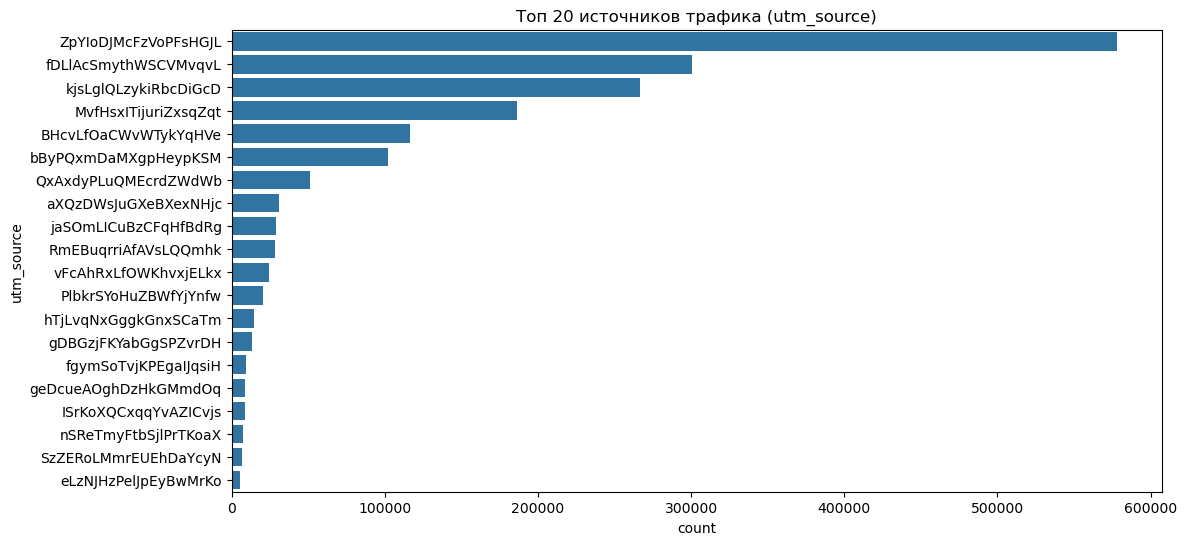

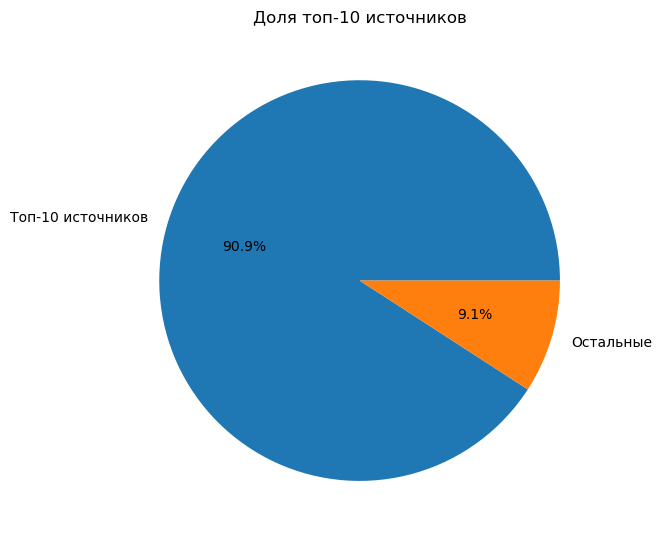

In [15]:
sessions_copy = sessions.copy()
hits_copy = hits.copy()
value_counts = sessions_copy['utm_campaign'].value_counts(normalize=True)
rare_categories = value_counts[value_counts < 0.01].index
sessions_copy['utm_campaign'] = sessions_copy['utm_campaign'].replace(rare_categories, 'other')

source_distribution = sessions_copy['utm_source'].value_counts(normalize=True) * 100

# Получаем топ-10 источников
top_10_sources = source_distribution.head(10)

# Считаем суммарный процент для топ-10
total_percent_top10 = top_10_sources.sum()

print(f"Топ-10 источников трафика составляют {total_percent_top10:.2f}% всех сессий")
print("\nДетальное распределение топ-10 источников:")
print(top_10_sources)

# Анализ utm_source
plt.figure(figsize=(12,6))
sns.countplot(y='utm_source', data=sessions_copy, order=sessions_copy['utm_source'].value_counts().iloc[:20].index)
plt.title('Топ 20 источников трафика (utm_source)')
plt.show()

plt.figure(figsize=(12, 6))

# Круговая диаграмма (топ-10 vs остальные)
ax2 = plt.subplot(1, 2, 2)
other_percent = 100 - total_percent_top10
pie_data = pd.Series([total_percent_top10, other_percent], 
                    index=['Топ-10 источников', 'Остальные'])
pie_data.plot.pie(autopct='%1.1f%%', ax=ax2)
plt.title('Доля топ-10 источников')

plt.tight_layout()
plt.show()

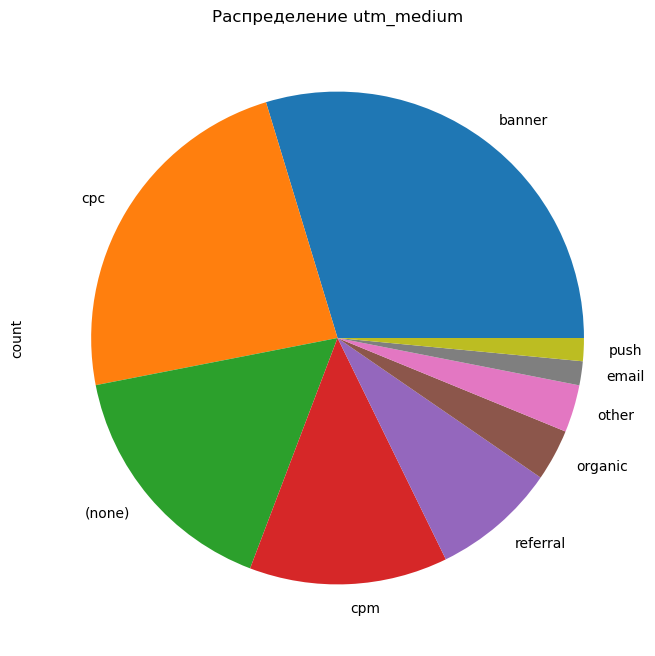

In [16]:
value_counts = sessions_copy['utm_medium'].value_counts(normalize=True)
rare_categories = value_counts[value_counts < 0.1].index
sessions_copy['utm_medium'] = sessions_copy['utm_medium'].replace(rare_categories, 'other')

# Анализ utm_medium
sessions_copy['utm_medium'].value_counts().plot.pie(figsize=(8,8))
plt.title('Распределение utm_medium')
plt.show()

Основные каналы (medium): banner, cpc, cpm, referral

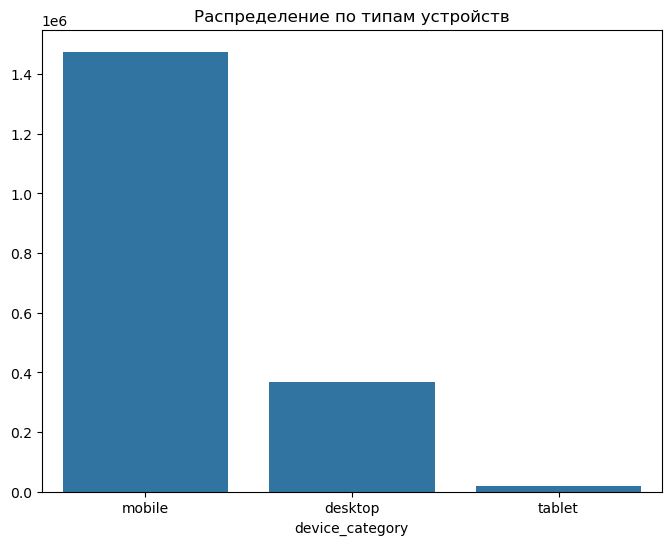

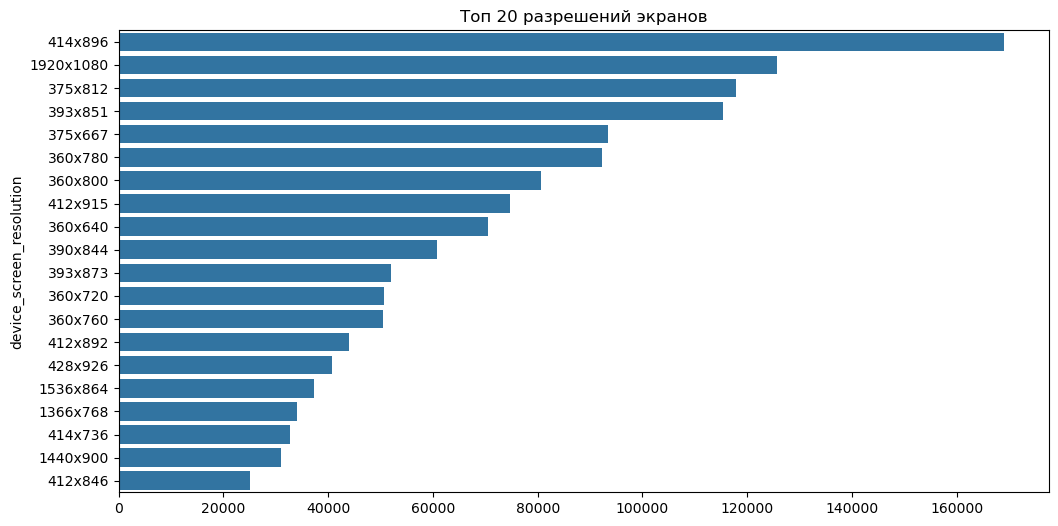

In [18]:
# Распределение по категориям устройств
device_counts = sessions_copy['device_category'].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=device_counts.index, y=device_counts.values)
plt.title('Распределение по типам устройств')
plt.show()

# Разрешения экранов (топ 20)
top_res = sessions_copy['device_screen_resolution'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(y=top_res.index, x=top_res.values)
plt.title('Топ 20 разрешений экранов')
plt.show()

Основные устройства: mobile (80%), desktop (20%), tablet (1%)

Популярные разрешения: 414x896(mobile), 1920x1080(desktop/tablet)

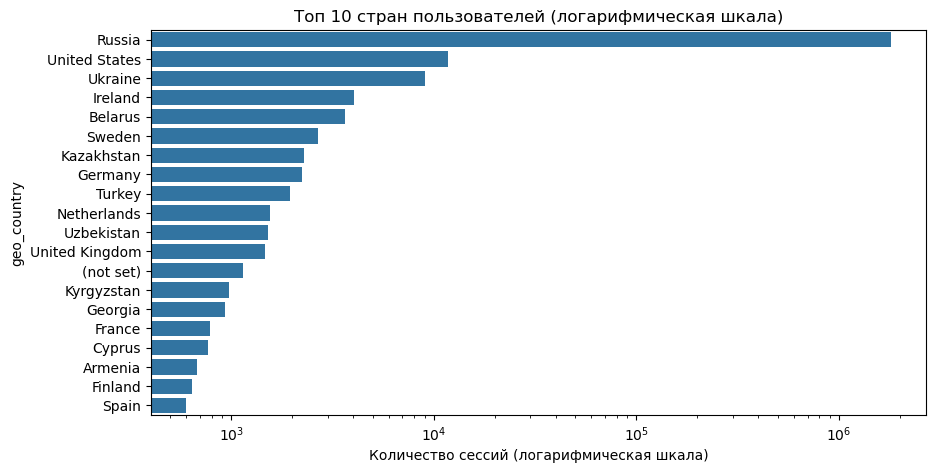

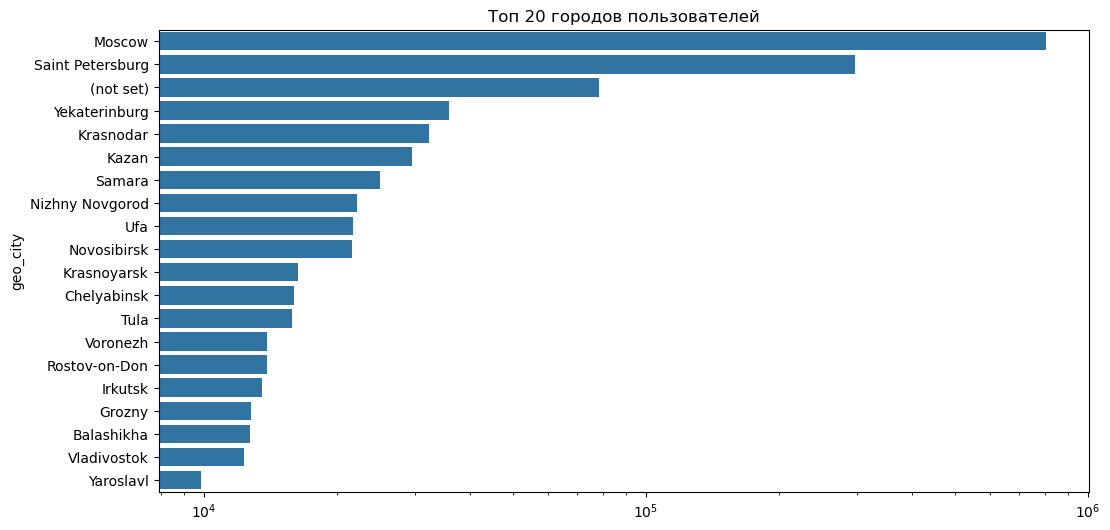

In [38]:
# Топ 10 стран
top_countries = sessions_copy['geo_country'].value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.xscale('log') 
plt.title('Топ 10 стран пользователей (логарифмическая шкала)')
plt.xlabel('Количество сессий (логарифмическая шкала)')
plt.show()

# Топ 20 городов
top_cities = sessions_copy['geo_city'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(y=top_cities.index, x=top_cities.values)
plt.xscale('log') 
plt.title('Топ 20 городов пользователей')
plt.show()

Основная страна: Россия (99%+ трафика)

Основные города: Москва, Санкт-Петербург

#### Анализ поведения пользователей

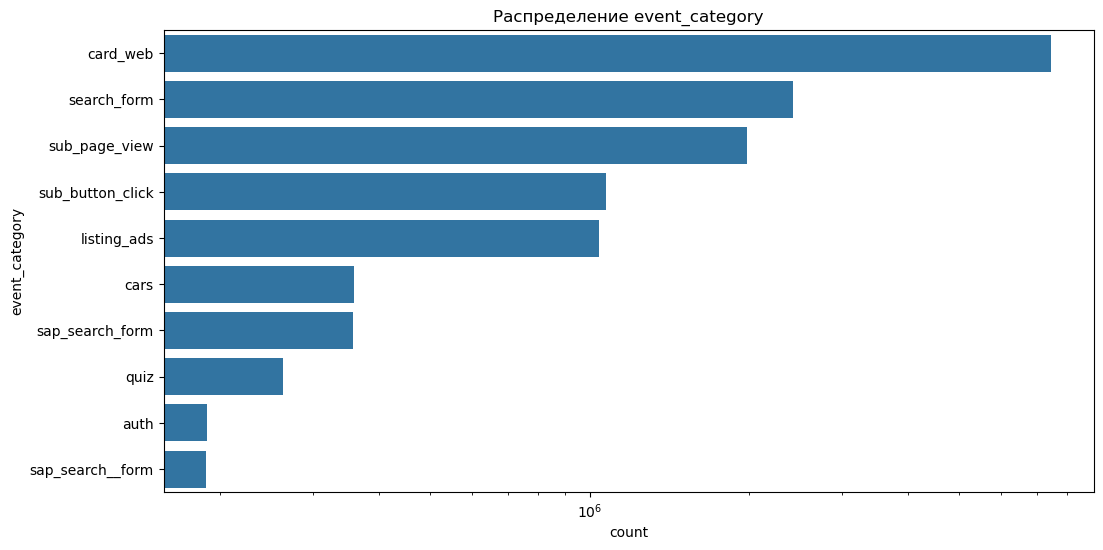

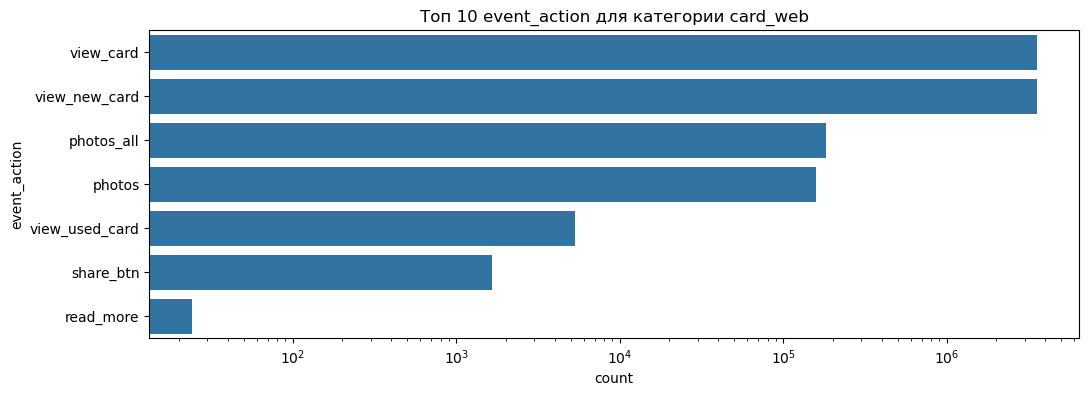

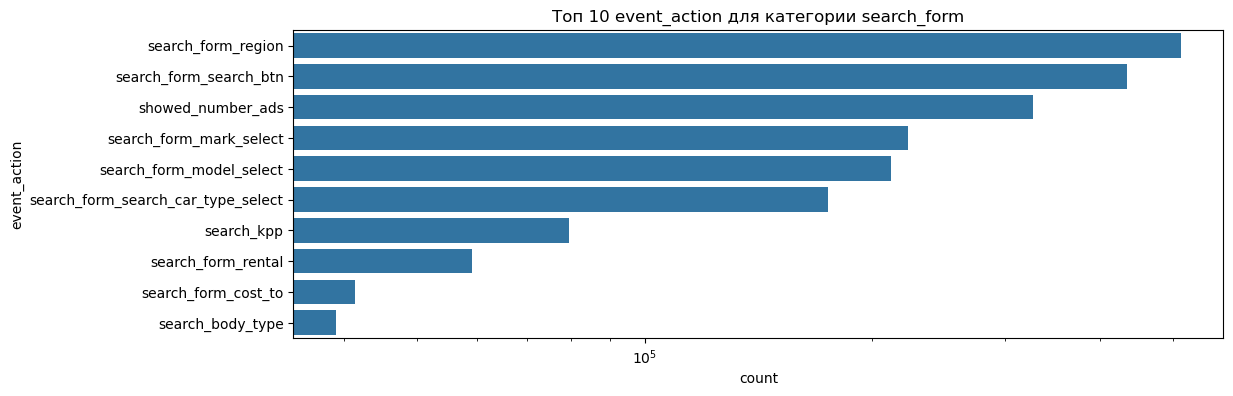

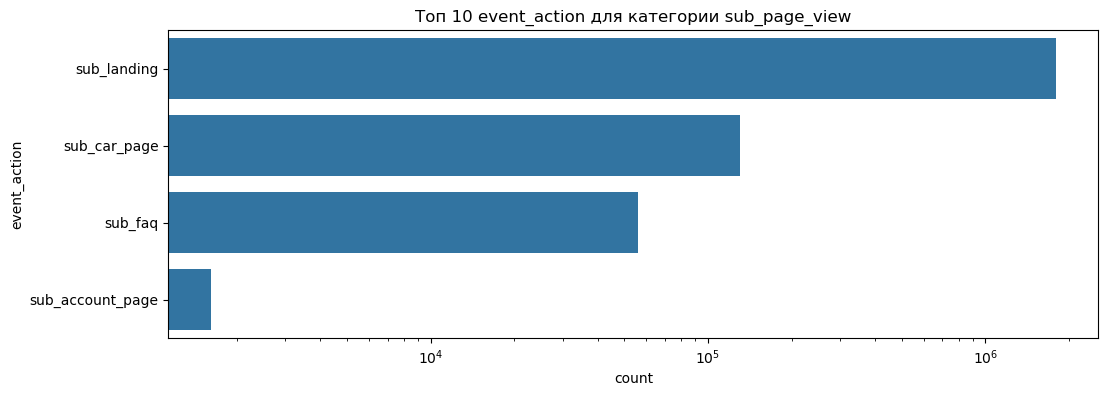

In [46]:
# Анализ event_category
plt.figure(figsize=(12,6))
sns.countplot(y='event_category', data=hits_copy,
             order=hits_copy['event_category'].value_counts().head(10).index)
plt.xscale('log') 
plt.title('Распределение event_category')
plt.show()

# Анализ event_action для главных категорий
main_cats = hits_copy['event_category'].value_counts().head(3).index
for cat in main_cats:
    plt.figure(figsize=(12,4))
    subset = hits_copy[hits_copy['event_category'] == cat]
    sns.countplot(y='event_action', data=subset,
                order=subset['event_action'].value_counts().head(10).index)
    plt.xscale('log') 
    plt.title(f'Топ 10 event_action для категории {cat}')
    plt.show()

Основные категории событий: card_web, search_form, sub_page_view и др.

Основные действия: view_card (card_web), search_form (search_form_region), sub_landing(sub_page_view)

#### Анализ временных закономерностей


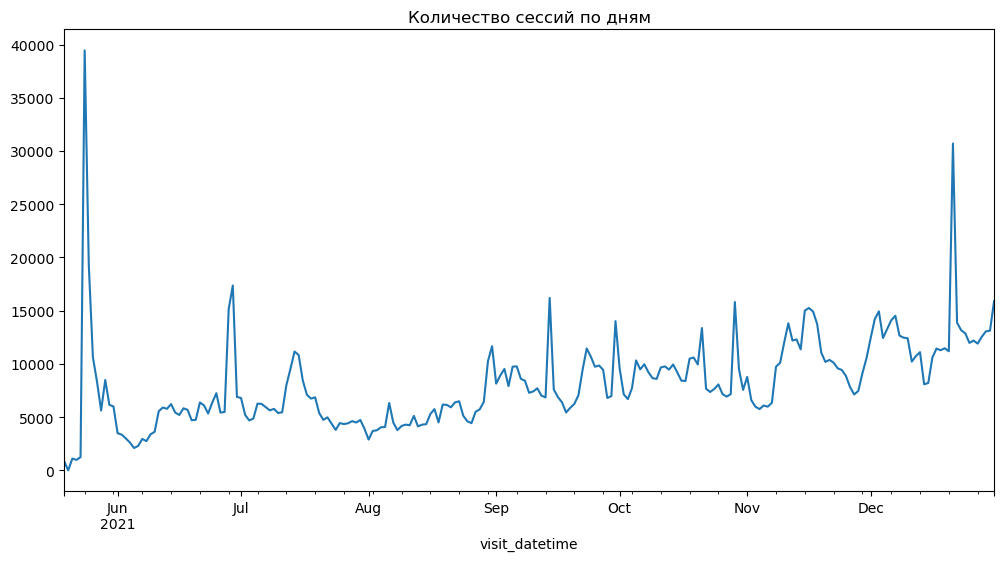

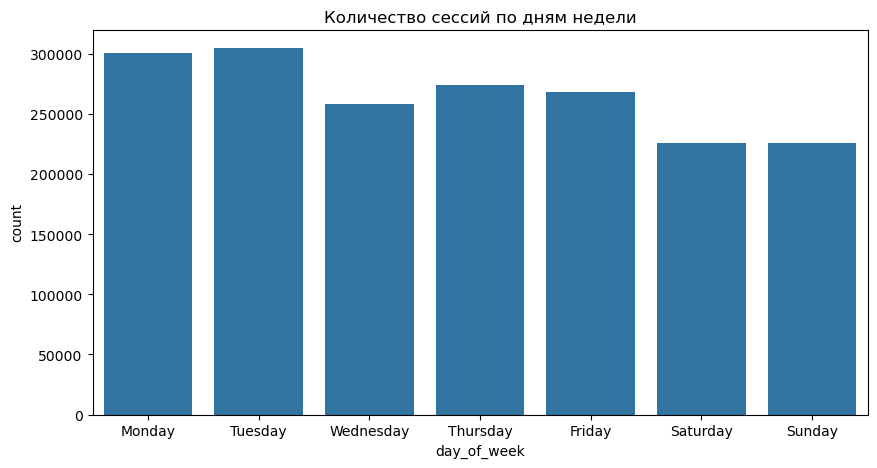

In [47]:
# Конвертируем в datetime
sessions_copy['visit_datetime'] = pd.to_datetime(sessions_copy['visit_date'] + ' ' + sessions_copy['visit_time'])

# Сессии по дням
daily_sessions = sessions_copy.set_index('visit_datetime').resample('D').size()
plt.figure(figsize=(12,6))
daily_sessions.plot()
plt.title('Количество сессий по дням')
plt.show()

# Сессии по дням недели
sessions_copy['day_of_week'] = sessions_copy['visit_datetime'].dt.day_name()
plt.figure(figsize=(10,5))
sns.countplot(x='day_of_week', data=sessions_copy, 
             order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Количество сессий по дням недели')
plt.show()

Присутствуют сезонные колебания

В выходные дни сессий меньше

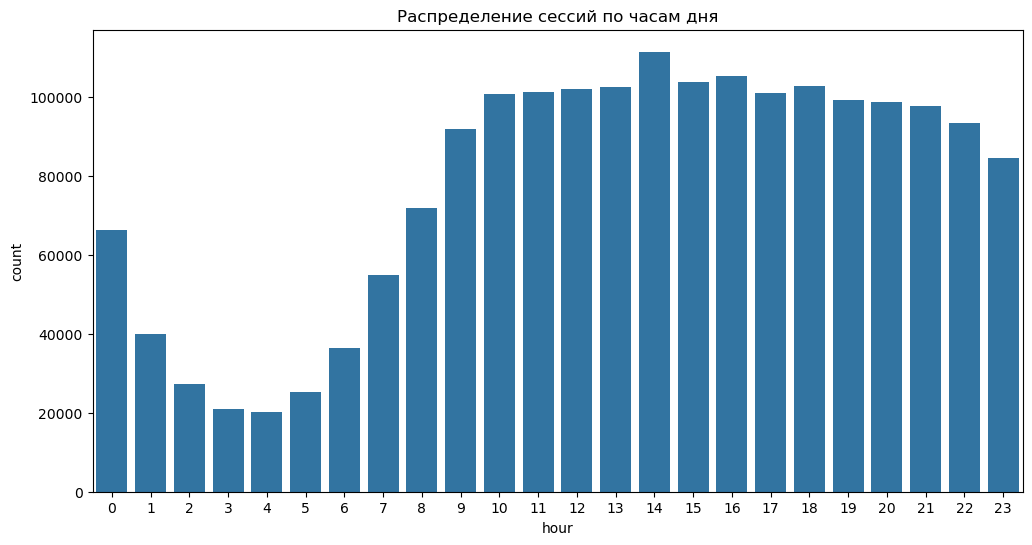

In [48]:
sessions_copy['hour'] = sessions_copy['visit_datetime'].dt.hour
plt.figure(figsize=(12,6))
sns.countplot(x='hour', data=sessions_copy)
plt.title('Распределение сессий по часам дня')
plt.show()

Пик активности: 9-23 часов

Минимум: 2-6 утра

#### Создание модели для предсказания вероятности совершения целевого действия


In [49]:
# Конфигурация моделей для различных бизнес-задач
MODEL_CONFIGS = {
    # Прогнозирование ключевых точек конверсии
    'lead_conversion': {
        'target_events': ['phone_entered', 'start_chat', 'sub_submit_success'],
        # Возможности улучшения:
        # - Оптимизация воронки продаж: выявление и усиление слабых мест в цепочке конверсии
        # - А/Б тестирование: сравнение эффективности разных версий ключевых страниц
        # - Персонализация: адаптация контента под поведенческие паттерны высококонвертируемых пользователей
        # - Приоритезация: фокус на лидах с высокой вероятностью конверсии для отдела продаж
    },
    
    # Анализ вовлеченности и пользовательского опыта
    'engagement': {
        'target_events': ['go_to_car_card', 'photos_all', 'search_form_search_btn'],
        # Возможности улучшения:
        # - Редизайн интерфейса: оптимизация навигации к популярному функционалу
        # - Контент-стратегия: увеличение доли вовлекающего контента
        # - Ускорение работы: оптимизация производительности часто используемых элементов
        # - Персонализация: рекомендации на основе паттернов взаимодействия
    },
    
    # Оптимизация дополнительных сервисов
    'upsell': {
        'target_events': ['click_pos_credit', 'click_insurance'],
        # Возможности улучшения:
        # - Размещение: оптимальные позиции для демонстрации дополнительных услуг
        # - Визуализация: улучшение представления комплексных решений
        # - Тайминг: показ допуслуг в моменты максимальной готовности клиента
        # - Бандлинг: формирование привлекательных пакетных предложений
    },

    # Предотвращение оттока пользователей
    'churn': {
        'target_events': ['search_form_clear'],
        # Возможности улучшения:
        # - Проактивные меры: триггеры для службы поддержки при риске оттока
        # - UX-анализ: выявление и исправление фрустрирующих элементов интерфейса
        # - Персональные офферы: специальные условия для пользователей с признаками ухода
        # - Обратная связь: механизмы сбора фидбека в проблемных точках
    }
}

In [50]:
class TargetProcessor(BaseEstimator, TransformerMixin):
    """Трансформер для создания целевой переменной"""
    def __init__(self, target_type, target_events):
        self.target_type = target_type  # 'conversion', 'engagement', 'upsell', 'churn'
        self.target_events = target_events  # Список целевых действий для выбраной бизнес-задачи  
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        if self.target_type == 'churn':
            df['target'] = df['event_action'].isin(self.target_events).astype(int)
        else:
            if not df['event_action'].isin(self.target_events).any():
                raise ValueError(f"Нет целевых событий {self.target_events} в данных!")
            # Создаем Series с отметками о целевых событиях
            has_target = df['event_action'].isin(self.target_events)
            # Группируем и находим сессии с хотя бы одним целевым событием
            target_sessions = set(df.loc[has_target, 'session_id'].unique())
            # Создаем target (1 если сессия в target_sessions, иначе 0)
            df['target'] = df['session_id'].isin(target_sessions).astype(int)
        return df  

In [51]:
# Создаем целевую переменную на основе выбранной бизнес-задачи
target_processor = TargetProcessor(
        target_type='lead_conversion',
        target_events=MODEL_CONFIGS['lead_conversion']['target_events']
    )
hits = target_processor.transform(hits.copy())

In [52]:
# Создаем два обучающих и два тестовых датафрейма(для имитации работы с реальными данными), предполагая, что на вход при рассчете вероятности 
# в реальных условиях также поступит два датафрейма 
sessions_with_target = pd.merge(sessions, hits, on='session_id', how='left')
sessions_with_target['target'] = sessions_with_target['target'].fillna(0)
sesions_unique = sessions_with_target['session_id'].unique().tolist()
train_sessions, test_sessions = train_test_split(
    sesions_unique,
    test_size=0.2,
    random_state=42,
    stratify=sessions_with_target.groupby('session_id')['target'].max()  # Стратификация по target
)
train_sessions_df = sessions[sessions['session_id'].isin(train_sessions)]
train_hits_df = hits[hits['session_id'].isin(train_sessions)]
test_sessions_df = sessions[sessions['session_id'].isin(test_sessions)]
test_hits_df = hits[hits['session_id'].isin(test_sessions)]
print(train_sessions_df.shape)
print(train_hits_df.shape)
print(test_sessions_df.shape)
print(test_hits_df.shape)

(1488033, 18)
(12539129, 12)
(372009, 18)
(3146090, 12)


In [53]:
# Готовим тренировочные данные для обучения
merged_train = pd.merge(
    train_sessions_df, 
    train_hits_df, 
    on='session_id', 
    how='left' 
)
# Заменяем специальные значения на NaN 
merged_train = merged_train.replace(['(not set)', '(none)'], np.nan)
# Проверяем результат 
print("Размер после объединения:", merged_train.shape)  

Размер после объединения: (12641170, 29)


In [55]:
# Создаем целевую переменную для тренировочных данных
merged_train['target'] = merged_train['target'].fillna(0)

y = merged_train['target'].reset_index(drop=True)
X = merged_train.drop(columns = ['target']).reset_index(drop=True)

In [56]:
# Готовим тестовые данные для оценки качества
merged_test = pd.merge(
    test_sessions_df, 
    test_hits_df, 
    on='session_id', 
    how='left'  
)
# Заменяем специальные значения на NaN 
merged_test = merged_test.replace(['(not set)', '(none)'], np.nan)
# Проверяем результат
print("Размер после объединения:", merged_test.shape)

Размер после объединения: (3171825, 29)


In [57]:
# Создаем целевую переменную для тестовых данных
merged_test['target'] = merged_test['target'].fillna(0)
y_test = merged_test['target'].reset_index(drop=True)
X_test = merged_test.drop(columns = ['target']).reset_index(drop=True)

In [58]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Трансформер для создания новых фич из сырых данных визитов.
    Создает временные, сессионные и пользовательские характеристики.
    """
    
    def __init__(self, verbose=True):
        self.verbose = verbose  # Флаг для отладочного вывода
        self.feature_names_out_ = None  # Для совместимости с sklearn
        
    def fit(self, df, y=None):
        """Не требует обучения, только для совместимости с sklearn API"""
        if self.verbose:
            print("\n[FeatureEngineer] FIT: Инициализация трансформера")
            print(f"Получено {len(df)} строк для анализа")
        return self
    
    def transform(self, df):
        """Основной метод преобразования данных"""
        if self.verbose:
            print("\n[FeatureEngineer] TRANSFORM: Начало обработки")
            print(f"Входные данные: {len(df)} строк, {len(df.columns)} колонок")
            print("Первые 5 строк входных данных:")
            print(df.head())
        
        # 1. Преобразование даты и времени
        if self.verbose:
            print("\n[1/3] Обработка временных меток...")
        
        df['visit_datetime'] = pd.to_datetime(df['visit_date'] + ' ' + df['visit_time'])
        df['hour'] = df['visit_datetime'].dt.hour
        df['day_of_week'] = df['visit_datetime'].dt.dayofweek
        
        if self.verbose:
            print("Созданы фичи:")
            print("- visit_datetime (объединенная дата-время)")
            print("- hour (час визита)")
            print("- day_of_week (день недели)")
            print("Пример преобразованных данных:")
            print(df[['visit_date', 'visit_time', 'visit_datetime', 'hour', 'day_of_week']].head())

        # 2. Статистика по сессиям
        if self.verbose:
            print("\n[2/3] Расчет сессионной статистики...")
        
        session_stats = (
            df.groupby('session_id')
            .agg(
                hit_count=('hit_number', 'count'),
                max_hit=('hit_number', 'max'),
                unique_actions=('event_action', 'nunique')
            )
            .reset_index()
        )
        
        if self.verbose:
            print("Рассчитаны сессионные метрики:")
            print("- hit_count (количество хитов в сессии)")
            print("- max_hit (максимальный номер хита)")
            print("- unique_actions (уникальные действия)")
            print("Пример сессионной статистики:")
            print(session_stats.head())

        # 3. Статистика по пользователям
        if self.verbose:
            print("\n[3/3] Расчет пользовательской статистики...")
        
        user_stats = (
            df.groupby('client_id')
            .agg(
                user_sessions=('session_id', 'nunique'),
                avg_hits_per_session=('hit_number', 'mean')
            )
            .reset_index()
        )
        
        if self.verbose:
            print("Рассчитаны пользовательские метрики:")
            print("- user_sessions (количество сессий пользователя)")
            print("- avg_hits_per_session (среднее число хитов на сессию)")
            print("Пример пользовательской статистики:")
            print(user_stats.head())

        # 4. Объединение всех данных
        if self.verbose:
            print("\nОбъединение всех данных...")
        
        result_df = (
            df
            .merge(session_stats, on='session_id', how='left')
            .merge(user_stats, on='client_id', how='left')
        )
        
        if self.verbose:
            print("\n[FeatureEngineer] Преобразование завершено")
            print(f"Итоговый DataFrame: {len(result_df)} строк, {len(result_df.columns)} колонок")
            print("Новые колонки в данных:")
            new_cols = set(result_df.columns) - set(df.columns)
            print(list(new_cols))
            print("\nПример итоговых данных:")
            print(result_df.head())
        
        return result_df
    
    def get_feature_names_out(self, input_features=None):
        """Возвращает имена выходных фич для совместимости с sklearn"""
        if self.verbose:
            print("\n[FeatureEngineer] Запрос имен выходных фич")
        return np.array(list(self.feature_names_out_)) if self.feature_names_out_ else None

In [59]:
class HitPagePathTransformer(BaseEstimator, TransformerMixin):
    """Трансформер для преобразования URL пути в числовую фичу - длину пути.
    Обрабатывает пути вида '/path/to/page?param=value', извлекая количество элементов пути.
    """
    
    def __init__(self, verbose=True):
        self.feature_names_out_ = ['hit_page_path_length']  # Название выходной фичи
        self.verbose = verbose  # Флаг отладочного вывода
        self.feature_names_in_ = None  # Сохраняет имена входных фич при обучении
        
    def fit(self, X, y=None):
        """Сохраняет имена фич для pandas DataFrame (если есть)"""
        if self.verbose:
            print("\n=== FIT ===")
            print(f"Входные данные типа: {type(X)}")
            
        if hasattr(X, 'columns'):
            self.feature_names_in_ = X.columns.tolist()
            if self.verbose:
                print(f"Обнаружены колонки: {self.feature_names_in_}")
                print(f"Первые 5 строк входных данных:\n{X.head()}")
                
        if self.verbose:
            print(f"Выходные фичи будут: {self.feature_names_out_}")
        return self
        
    def transform(self, X):
        """Преобразует путь страницы в длину пути (количество элементов)
        Обрабатывает как DataFrame, так и numpy array.
        Удаляет параметры запроса (все что после ?) перед подсчетом элементов пути.
        """
        if self.verbose:
            print("\n=== TRANSFORM ===")
            print(f"Тип входных данных: {type(X)}")
            
        def path_corrector(x):
            """Внутренняя функция обработки одного URL:
            - Обрабатывает NaN значения
            - Удаляет параметры запроса (после ?)
            - Разбивает путь по '/' и считает количество элементов
            """
            if pd.isna(x):
                return 0
            # Разделяем по ? и берем первую часть (путь)
            path_part = str(x).split('?')[0]  
            # Разбиваем путь по '/' и фильтруем пустые элементы
            path_elements = [p for p in path_part.split('/') if p]  
            return len(path_elements)
        
        if isinstance(X, pd.DataFrame):
            if self.verbose:
                print(f"Обрабатываю DataFrame с колонками: {X.columns.tolist()}")
                print("Пример данных до преобразования:")
                print(X['hit_page_path'].head())
            
            result = X.copy()
            result['hit_page_path_length'] = X['hit_page_path'].apply(path_corrector)
            result = result.drop(columns=['hit_page_path'])
            
            if self.verbose:
                print("\nРезультат преобразования:")
                print(result.head())
                print(f"Выходные колонки: {result.columns.tolist()}")
            
            return result
            
        elif isinstance(X, np.ndarray):
            if self.verbose:
                print(f"Обрабатываю numpy array с формой: {X.shape}")
                print(f"Первые 5 значений:\n{X[:5]}")
            
            result = np.array([[path_corrector(x)] for x in X])
            
            if self.verbose:
                print("\nРезультат преобразования:")
                print(f"Первые 5 значений:\n{result[:5]}")
            
            return result
            
        else:
            raise TypeError(f"Неподдерживаемый тип данных: {type(X)}")
    
    def get_feature_names_out(self, input_features=None):
        """Возвращает имена выходных фич (совместимость с sklearn ColumnTransformer)"""
        check_is_fitted(self, 'feature_names_out_')
        if self.verbose:
            print("\n=== GET_FEATURE_NAMES_OUT ===")
            print(f"Возвращаемые фичи: {self.feature_names_out_}")
        return np.array(self.feature_names_out_)

In [60]:
class SafeCatBoostEncoder(BaseEstimator, TransformerMixin):
    """Безопасный CatBoostEncoder с обработкой пропущенных значений и проверкой входных данных.

    Особенности:
    - Автоматически заполняет пропуски указанным значением (по умолчанию 'unknown')
    - Проверяет наличие всех указанных колонок
    - Сохраняет имена фич для совместимости с sklearn Pipeline
    - Подробное логирование процесса при verbose=True
    """

    def __init__(self, cols, fill_value='unknown', verbose=True):
        """
        Инициализация кодировщика.

        Параметры:
        ----------
        cols : str или list
            Колонки для кодирования
        fill_value : str, optional
            Значение для заполнения пропусков (по умолчанию 'unknown')
        verbose : bool, optional
            Флаг подробного вывода (по умолчанию True)
        """

        self.cols = cols if isinstance(cols, list) else [cols]  # Всегда работаем с list
        self.fill_value = fill_value
        self.encoder = None  # Будет инициализирован при обучении
        self.feature_names_in_ = None  # Сохранит имена входных фич
        self.verbose = verbose

    def fit(self, X, y):
        """Обучение кодировщика на данных.

        Этапы:
        1. Проверка и преобразование входных данных
        2. Заполнение пропусков
        3. Обучение CatBoostEncoder
        """
        # Шаг 1: Преобразование в DataFrame и сохранение имен фич
        X = pd.DataFrame(X)
        self.feature_names_in_ = X.columns.tolist()

        if self.verbose:
            print("\n=== FIT ===")
            print(f"Входные колонки: {self.feature_names_in_}")
            print(f"Колонки для кодирования: {self.cols}")
            print(f"Первые 5 строк до обработки:\n{X[self.cols].head()}")

        # Шаг 2: Проверка наличия всех указанных колонок
        missing = set(self.cols) - set(X.columns)
        if missing:
            raise ValueError(f"Отсутствуют колонки: {missing}")

        # Шаг 3: Заполнение пропусков указанным значением
        X_filled = X[self.cols].fillna(self.fill_value)

        if self.verbose:
            print(f"\nПосле заполнения пропусков ('{self.fill_value}'):\n{X_filled.head()}")

        # Шаг 4: Обучение CatBoostEncoder
        X_filled = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        self.encoder = CatBoostEncoder(cols=self.cols)
        self.encoder.fit(X_filled, y)

        if self.verbose:
            print("\nКодировщик успешно обучен!")
            print(f"Пример закодированных значений (первые 5):")
            encoded_sample = self.encoder.transform(X_filled.head())
            print(encoded_sample.head())

        return self

    def transform(self, X):
        """Применение обученного кодировщика к новым данным.

        Этапы:
        1. Проверка структуры входных данных
        2. Заполнение пропусков
        3. Применение кодирования
        """
        # Шаг 1: Преобразование в DataFrame с проверкой колонок
        X = pd.DataFrame(X, columns=self.feature_names_in_)

        if self.verbose:
            print("\n=== TRANSFORM ===")
            print(f"Входные колонки: {self.feature_names_in_}")
            print(f"Первые 5 строк до обработки:\n{X[self.cols].head()}")

        # Шаг 2: Заполнение пропусков (для новых данных)
        X[self.cols] = X[self.cols].fillna(self.fill_value)

        if self.verbose:
            print(f"\nПосле заполнения пропусков ('{self.fill_value}'):\n{X[self.cols].head()}")

        # Шаг 3: Применение обученного кодировщика
        X[self.cols] = self.encoder.transform(X[self.cols])

        if self.verbose:
            print("\nПосле кодирования CatBoostEncoder:")
            print(X[self.cols].head())

        return X

    def get_feature_names_out(self, input_features=None):
        """Возвращает имена фичей после преобразования.

        Для CatBoostEncoder имена фичей не меняются - исходные категориальные колонки
        заменяются на числовые значения с теми же именами.
        """
        check_is_fitted(self, 'feature_names_in_')
        if input_features is not None:
            # Проверяем соответствие переданных имен обученным
            if len(input_features) != len(self.feature_names_in_):
                raise ValueError("Несоответствие числа фичей.")
            return np.array(input_features)
        return np.array(self.feature_names_in_)

In [62]:
class EnsureDataFrame(BaseEstimator, TransformerMixin):
    """Гарантирует DataFrame с правильными именами столбцов из preprocessor и поддерживает undersampling
    
    Параметры:
    ----------
    preprocessor : объект, optional (default=None)
        Препроцессор, из которого можно получить имена фичей (через get_feature_names_out())
    verbose : bool, optional (default=True)
        Если True, выводит информацию о процессе обработки
        
    Атрибуты:
    ---------
    feature_names_ : list или None
        Список имен столбцов, полученных из препроцессора
    y_resampled_ : array-like или None
        Хранит метки после ресемплинга (если применяется)
    """
    
    def __init__(self, preprocessor=None, verbose=True):
        self.preprocessor = preprocessor
        self.feature_names_ = None  # Будет заполнено в fit()
        self.verbose = verbose
        self.y_resampled_ = None  # Для хранения ресемплинговых меток
        
    def fit(self, X, y=None):
        """Получает имена столбцов из препроцессора (если он задан)
        
        Параметры:
        ----------
        X : array-like или DataFrame
            Входные данные
        y : array-like, optional
            Метки (не используется, нужен для совместимости)
            
        Возвращает:
        -----------
        self : объект
            Текущий экземпляр трансформера
        """
        if self.verbose:
            print("\n[EnsureDataFrame] FIT: получение имен столбцов")
        
        # Получаем имена столбцов из preprocessor
        if self.preprocessor is not None:
            try:
                self.feature_names_ = self.preprocessor.get_feature_names_out()
                if self.verbose:
                    print(f"Получены имена столбцов ({len(self.feature_names_)}):")
                    print(self.feature_names_)
            except Exception as e:
                if self.verbose:
                    print(f"Ошибка получения имен столбцов: {str(e)}")
                raise
        
        return self
        
    def transform(self, X):
        """Преобразует входные данные в DataFrame с правильными именами столбцов
        
        Параметры:
        ----------
        X : array-like или DataFrame
            Входные данные для преобразования
            
        Возвращает:
        -----------
        df : DataFrame
            DataFrame с именами столбцов (если они были получены)
        """
        if self.verbose:
            print("\n[EnsureDataFrame] TRANSFORM: создание DataFrame")
            print(f"Тип входных данных: {type(X)}")
            print(f"Форма данных: {X.shape}")
        
        # Создаем DataFrame с именами столбцов или без
        if self.feature_names_ is not None and len(self.feature_names_) == X.shape[1]:
            df = pd.DataFrame(X, columns=self.feature_names_)
            if self.verbose:
                print("Создан DataFrame с именами столбцов:")
                print(df.head(2))
        else:
            df = pd.DataFrame(X)
            if self.verbose:
                print("Создан DataFrame без имен столбцов:")
                print(df.head(2))
        
        return df
    
    def fit_resample(self, X, y):
        """Метод для поддержки undersampling в ImbPipeline
        
        Параметры:
        ----------
        X : array-like или DataFrame
            Входные данные
        y : array-like
            Метки
            
        Возвращает:
        -----------
        X_transformed : DataFrame
            Преобразованные данные
        y : array-like
            Метки (без изменений)
        """
        if self.verbose:
            print("\n[EnsureDataFrame] FIT_RESAMPLE: обработка undersampling")
        
        # 1. Сначала получаем имена столбцов (аналогично fit)
        self.fit(X, y)
        
        # 2. Применяем transform к X
        X_transformed = self.transform(X)
        
        # 3. Сохраняем y (без изменений, так как undersampling будет применен раньше)
        self.y_resampled_ = y
        
        if self.verbose:
            print(f"Форма X после transform: {X_transformed.shape}")
            print(f"Форма y: {y.shape}")
        
        return X_transformed, y

In [96]:

# 1. Предобработка данных 
numeric_features = ['visit_number', 'hit_number', 'hour', 'day_of_week', 
                       'hit_count', 'max_hit', 'unique_actions', 
                       'user_sessions', 'avg_hits_per_session']
category_features = ['utm_source', 'utm_campaign', 'utm_adcontent','device_browser', 'geo_city', 'device_screen_resolution', 'utm_medium', 'device_brand']
other_category_features = ['device_category']
other_numeric_features = ['hit_page_path']

# Создаем preprocessor с правильными именами признаков

preprocessor = ColumnTransformer(
    
    transformers=[
        ('num', ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('encode_utm', SafeCatBoostEncoder(cols=category_features), 
         category_features),
        ('hit_path', ImbPipeline([
            ('transformer', HitPagePathTransformer()),
            ('scaler', StandardScaler())
        ]), other_numeric_features),
        ('cat_onehot', ImbPipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), other_category_features)      
        
        ],
    remainder='drop',
    verbose_feature_names_out=False
    
)
ensure_df = EnsureDataFrame(preprocessor=preprocessor, verbose=True)

# Собираем пайплайн для предобработки данных
preprocessing_pipeline = ImbPipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('ensure_df', EnsureDataFrame(preprocessor=preprocessor, verbose=True))
])

X_processed, y_processed = preprocessing_pipeline.fit_resample(X, y)



[FeatureEngineer] FIT: Инициализация трансформера
Получено 12641170 строк для анализа

[FeatureEngineer] TRANSFORM: Начало обработки
Входные данные: 12641170 строк, 31 колонок
Первые 5 строк входных данных:
                                  session_id              client_id  \
0  9055434745589932991.1637753792.1637753792  2108382700.1637753791   
1  9055434745589932991.1637753792.1637753792  2108382700.1637753791   
2   905544597018549464.1636867290.1636867290   210838531.1636867288   
3  9055446045651783499.1640648526.1640648526  2108385331.1640648523   
4  9055446045651783499.1640648526.1640648526  2108385331.1640648523   

   visit_date visit_time  visit_number            utm_source utm_medium  \
0  2021-11-24   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1  2021-11-24   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
2  2021-11-14   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
3  2021-12-28   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     

In [98]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2284504 entries, 0 to 2284503
Data columns (total 21 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   visit_number              float64
 1   hit_number                float64
 2   hour                      float64
 3   day_of_week               float64
 4   hit_count                 float64
 5   max_hit                   float64
 6   unique_actions            float64
 7   user_sessions             float64
 8   avg_hits_per_session      float64
 9   utm_source                float64
 10  utm_campaign              float64
 11  utm_adcontent             float64
 12  device_browser            float64
 13  geo_city                  float64
 14  device_screen_resolution  float64
 15  utm_medium                float64
 16  device_brand              float64
 17  hit_page_path_length      float64
 18  device_category_desktop   float64
 19  device_category_mobile    float64
 20  device_category_tablet  

In [100]:
y_processed.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2284504 entries, 0 to 2284503
Series name: target
Non-Null Count    Dtype  
--------------    -----  
2284504 non-null  float64
dtypes: float64(1)
memory usage: 17.4 MB


In [70]:
# Матрица корреляций 
df_corr = X_processed.copy()
df_corr['target'] = y_processed
# Выделение значений более 0.7
corr_matrix = df_corr.corr()
def highlight_greater_than(val):
    color = 'pink' if (val > 0.7) | ( val <-0.7) else 'lightgreen'
    return f'background-color: {color}'
cor_data_styler = corr_matrix.style.apply(lambda x: x.map(highlight_greater_than), axis=None)
cor_data_styler

,visit_number,hit_number,hour,day_of_week,hit_count,max_hit,unique_actions,user_sessions,avg_hits_per_session,utm_source,utm_campaign,utm_adcontent,device_browser,geo_city,device_screen_resolution,utm_medium,device_brand,hit_page_path_length,device_category_desktop,device_category_mobile,device_category_tablet,target
visit_number,1.000000,0.022319,0.002108,-0.028452,0.021292,0.028230,0.022152,0.882670,0.022475,0.005949,0.005940,0.024309,0.050243,-0.019238,0.103529,-0.019086,-0.004051,0.017029,0.120272,-0.118179,-0.003481,0.038381
hit_number,0.022319,1.000000,-0.007391,-0.002956,0.722022,0.777295,0.417064,0.030650,0.740704,0.122675,0.017174,0.043738,0.041353,0.052390,0.038665,0.099233,0.039876,0.128718,0.095932,-0.096075,0.005715,0.221249
hour,0.002108,-0.007391,1.000000,-0.012485,-0.008485,-0.007413,0.008964,0.004150,-0.006301,-0.002769,-0.003926,0.007923,-0.015587,-0.001269,0.004354,-0.000990,-0.008007,0.006465,0.015977,-0.017788,0.009324,0.003441
day_of_week,-0.028452,-0.002956,-0.012485,1.000000,0.014144,0.000461,0.016443,-0.033928,-0.000083,-0.006376,0.013248,-0.027482,-0.003696,0.011549,-0.003616,-0.001316,0.020821,0.018326,-0.094237,0.090310,0.013440,0.004947
hit_count,0.021292,0.722022,-0.008485,0.014144,1.000000,0.938703,0.559686,0.035323,0.871217,0.095149,0.018353,0.046347,0.062058,0.069537,0.056379,0.068697,0.073043,0.062361,0.098596,-0.099453,0.009199,0.288923
max_hit,0.028230,0.777295,-0.007413,0.000461,0.938703,1.000000,0.544947,0.040003,0.929271,0.139285,0.021031,0.052980,0.055290,0.067417,0.051510,0.109926,0.060037,0.066250,0.115944,-0.116416,0.008307,0.283990
unique_actions,0.022152,0.417064,0.008964,0.016443,0.559686,0.544947,1.000000,0.025088,0.501249,0.188793,0.119810,0.112608,0.105904,0.092581,0.094203,0.176988,0.085627,0.022465,0.062246,-0.061375,-0.000808,0.552254
user_sessions,0.882670,0.030650,0.004150,-0.033928,0.035323,0.040003,0.025088,1.000000,0.026852,0.003276,-0.004241,0.013362,0.061704,-0.026298,0.101428,-0.018002,-0.003699,0.008147,0.142614,-0.140656,-0.001674,0.044521
avg_hits_per_session,0.022475,0.740704,-0.006301,-0.000083,0.871217,0.929271,0.501249,0.026852,1.000000,0.150272,0.024147,0.058359,0.051905,0.069849,0.046511,0.119572,0.054756,0.065836,0.127320,-0.127052,0.005441,0.270384
utm_source,0.005949,0.122675,-0.002769,-0.006376,0.095149,0.139285,0.188793,0.003276,0.150272,1.000000,0.384670,0.353299,0.155388,0.071491,0.067939,0.690320,0.056379,-0.043078,-0.013137,0.015714,-0.012761,0.179554


In [71]:
# Топ коррелирующих признаков с целевой переменной
target_corr = corr_matrix['target'].sort_values(ascending=False)
print("Топ коррелирующих признаков:")
print(target_corr[1:11])  # исключаем сам таргет

Топ коррелирующих признаков:
unique_actions              0.552254
hit_count                   0.288923
max_hit                     0.283990
avg_hits_per_session        0.270384
hit_number                  0.221249
utm_source                  0.179554
utm_campaign                0.176364
utm_medium                  0.162275
utm_adcontent               0.112030
device_screen_resolution    0.111070
Name: target, dtype: float64


In [72]:
# Признаки с высокой взаимной корреляцией
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Применяем маску и "расплавляем" матрицу в long-формат
corr_pairs = corr_matrix.mask(mask).stack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Фильтруем только высокие корреляции (по модулю)
high_corr = corr_pairs[
    (abs(corr_pairs['Correlation']) > 0.7) &  # Порог корреляции
    (corr_pairs['Feature1'] != corr_pairs['Feature2'])  # Исключаем диагональ
].sort_values(by='Correlation', ascending=False)

# Выводим результат
print("Признаки с высокой корреляцией:")
display(high_corr)

Признаки с высокой корреляцией:


,Feature1,Feature2,Correlation
14,max_hit,hit_count,0.938703
33,avg_hits_per_session,max_hit,0.929271
21,user_sessions,visit_number,0.882670
32,avg_hits_per_session,hit_count,0.871217
11,max_hit,hit_number,0.777295
29,avg_hits_per_session,hit_number,0.740704
7,hit_count,hit_number,0.722022
189,device_category_mobile,device_category_desktop,-0.977015


In [92]:
X_processed

,visit_number,hit_number,hour,day_of_week,hit_count,max_hit,unique_actions,user_sessions,avg_hits_per_session,utm_source,utm_campaign,utm_adcontent,device_browser,geo_city,device_screen_resolution,utm_medium,device_brand,hit_page_path_length,device_category_desktop,device_category_mobile,device_category_tablet,target
0,-0.135036,-0.679036,1.021190,0.630513,-0.800400,-0.851650,-1.129981,-0.179517,-0.948802,0.075162,0.090827,0.097295,0.100192,0.122244,0.106303,0.090360,0.104935,-0.542327,0.0,1.0,0.0,0.0
1,-0.135036,2.079523,-0.772875,0.630513,1.305168,1.068513,0.438008,1.180179,0.426622,0.075162,0.090827,0.097295,0.080723,0.086169,0.081066,0.090360,0.073293,-0.542327,0.0,1.0,0.0,0.0
2,-0.135036,-0.644118,-0.609778,-0.377661,-0.771947,-0.695358,-0.933982,-0.179517,-0.747787,0.108116,0.098626,0.097295,0.080723,0.086169,0.081066,0.096289,0.073293,-1.113622,0.0,1.0,0.0,0.0
3,-0.055835,-0.260015,0.531899,-0.881748,-0.117513,-0.137171,-0.345986,-0.111532,0.036567,0.075132,0.090827,0.097295,0.093131,0.091458,0.087355,0.079859,0.090360,1.742852,1.0,0.0,0.0,0.0
4,-0.135036,-0.434607,0.858093,1.638687,-0.715039,-0.695358,-0.737983,-0.179517,-0.781805,0.075162,0.090827,0.097295,0.100192,0.081439,0.105539,0.090360,0.106713,-0.542327,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284499,-0.135036,-0.364770,-0.935972,-1.385835,0.053208,-0.181826,1.418001,-0.179517,-0.229789,0.075162,0.090827,0.097295,0.100192,0.086169,0.095487,0.090360,0.095515,1.742852,0.0,1.0,0.0,1.0
2284500,-0.135036,-0.085422,-0.935972,-1.385835,0.053208,-0.181826,1.418001,-0.179517,-0.229789,0.075162,0.090827,0.097295,0.100192,0.086169,0.095487,0.090360,0.095515,1.742852,0.0,1.0,0.0,1.0
2284501,-0.135036,-0.190178,-0.935972,-1.385835,0.053208,-0.181826,1.418001,-0.179517,-0.229789,0.075162,0.090827,0.097295,0.100192,0.086169,0.095487,0.090360,0.095515,1.742852,0.0,1.0,0.0,1.0
2284502,-0.135036,0.159007,-0.935972,-1.385835,0.053208,-0.181826,1.418001,-0.179517,-0.229789,0.075162,0.090827,0.097295,0.100192,0.086169,0.095487,0.090360,0.095515,1.742852,0.0,1.0,0.0,1.0


[I 2025-05-06 08:13:38,482] A new study created in memory with name: no-name-9a71da1b-24af-4c11-8a7a-4eb843a57967


Starting optimization...


<Figure size 1200x800 with 0 Axes>

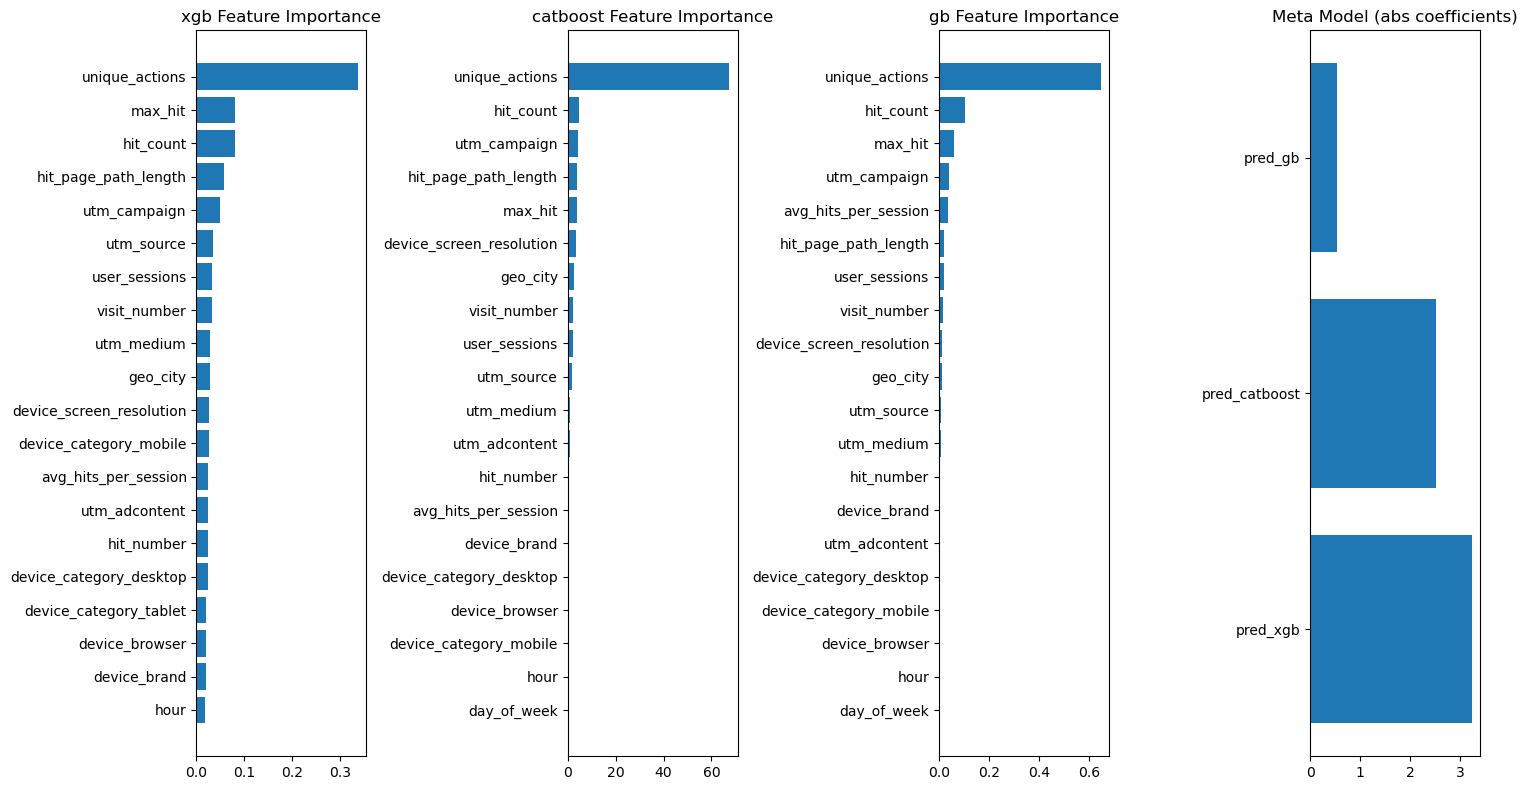


Checking for potential data leaks:
  - Features with zero importance in at least one model: ['device_category_tablet']


[I 2025-05-06 08:50:57,185] Trial 0 finished with value: 0.8882752263788694 and parameters: {'xgb_n_estimators': 144, 'xgb_max_depth': 10, 'xgb_lr': 0.1205712628744377, 'xgb_min_child_weight': 6.387926357773329, 'xgb_gamma': 0.7800932022121826, 'xgb_subsample': 0.5779972601681014, 'xgb_colsample_bytree': 0.5290418060840998, 'xgb_alpha': 0.08499808989182997, 'xgb_lambda': 0.0006440507553993703, 'catboost_iter': 227, 'catboost_depth': 2, 'catboost_lr': 0.2708160864249968, 'cb_l2_leaf_reg': 8.491983767203795, 'cb_border_count': 79, 'cb_random_strength': 1.9000671753502962, 'cb_bagging_temperature': 0.18340450985343382, 'cb_min_data_in_leaf': 16, 'gb_n_estimators': 181, 'gb_max_depth': 5, 'gb_learning_rate': 0.02692655251486473, 'gb_min_samples_split': 13, 'gb_min_samples_leaf': 3, 'gb_max_features': 0.3629301836816964, 'gb_subsample': 0.6831809216468459, 'meta_C': 0.23345864076016243, 'meta_max_iter': 1678}. Best is trial 0 with value: 0.8882752263788694.


| Trial | ROC-AUC  |
|-------|----------|
|     0 | 0.888275 |


[I 2025-05-06 09:35:52,164] Trial 1 finished with value: 0.8840896701402909 and parameters: {'xgb_n_estimators': 100, 'xgb_max_depth': 6, 'xgb_lr': 0.07500118950416987, 'xgb_min_child_weight': 1.4180537144799796, 'xgb_gamma': 3.0377242595071916, 'xgb_subsample': 0.5852620618436457, 'xgb_colsample_bytree': 0.5325257964926398, 'xgb_alpha': 0.39001768308022033, 'xgb_lambda': 0.530953226900921, 'catboost_iter': 252, 'catboost_depth': 4, 'catboost_lr': 0.013940346079873234, 'cb_l2_leaf_reg': 7.158097238609412, 'cb_border_count': 130, 'cb_random_strength': 1.3081785249633104, 'cb_bagging_temperature': 0.4951769101112702, 'cb_min_data_in_leaf': 2, 'gb_n_estimators': 278, 'gb_max_depth': 4, 'gb_learning_rate': 0.09519754482692679, 'gb_min_samples_split': 7, 'gb_min_samples_leaf': 11, 'gb_max_features': 0.5920392514089517, 'gb_subsample': 0.5924272277627636, 'meta_C': 8.10501612641158, 'meta_max_iter': 1663}. Best is trial 0 with value: 0.8882752263788694.


|     1 | 0.884090 |


[I 2025-05-06 11:53:07,709] Trial 2 finished with value: 0.8890063960237878 and parameters: {'xgb_n_estimators': 285, 'xgb_max_depth': 10, 'xgb_lr': 0.0764136186923332, 'xgb_min_child_weight': 9.296868115208051, 'xgb_gamma': 0.4424625102595975, 'xgb_subsample': 0.5979914312095727, 'xgb_colsample_bytree': 0.522613644455269, 'xgb_alpha': 4.005370050283172e-06, 'xgb_lambda': 1.2865252594826764e-05, 'catboost_iter': 118, 'catboost_depth': 9, 'catboost_lr': 0.03364867144187954, 'cb_l2_leaf_reg': 3.5284105871864266, 'cb_border_count': 153, 'cb_random_strength': 1.4951498272501504, 'cb_bagging_temperature': 0.8021969807540397, 'cb_min_data_in_leaf': 4, 'gb_n_estimators': 297, 'gb_max_depth': 8, 'gb_learning_rate': 0.019657448966046126, 'gb_min_samples_split': 2, 'gb_min_samples_leaf': 17, 'gb_max_features': 0.7361716094628554, 'gb_subsample': 0.8645035840204937, 'meta_C': 2.059733535743719, 'meta_max_iter': 611}. Best is trial 2 with value: 0.8890063960237878.


|     2 | 0.889006 |


[I 2025-05-06 12:12:22,392] Trial 3 finished with value: 0.8826371507077357 and parameters: {'xgb_n_estimators': 139, 'xgb_max_depth': 3, 'xgb_lr': 0.18832519048593593, 'xgb_min_child_weight': 6.609683141448022, 'xgb_gamma': 1.654490124263246, 'xgb_subsample': 0.5317791751430119, 'xgb_colsample_bytree': 0.6554911608578311, 'xgb_alpha': 3.994538177154855e-06, 'xgb_lambda': 0.006868302692995721, 'catboost_iter': 210, 'catboost_depth': 9, 'catboost_lr': 0.049833191601257244, 'cb_l2_leaf_reg': 2.0763482134447155, 'cb_border_count': 191, 'cb_random_strength': 7.631771981307285, 'cb_bagging_temperature': 0.5612771975694962, 'cb_min_data_in_leaf': 39, 'gb_n_estimators': 173, 'gb_max_depth': 6, 'gb_learning_rate': 0.042808491617570936, 'gb_min_samples_split': 2, 'gb_min_samples_leaf': 3, 'gb_max_features': 0.12828626711806082, 'gb_subsample': 0.8182052056318903, 'meta_C': 0.08771380343280563, 'meta_max_iter': 1263}. Best is trial 2 with value: 0.8890063960237878.


|     3 | 0.882637 |


[I 2025-05-06 13:37:28,841] Trial 4 finished with value: 0.8853452259315062 and parameters: {'xgb_n_estimators': 277, 'xgb_max_depth': 4, 'xgb_lr': 0.040381768820718394, 'xgb_min_child_weight': 7.799960246887438, 'xgb_gamma': 1.1439908274581123, 'xgb_subsample': 0.5384899549143964, 'xgb_colsample_bytree': 0.6448757264568841, 'xgb_alpha': 1.9488135833929595e-07, 'xgb_lambda': 0.2738931802392973, 'catboost_iter': 252, 'catboost_depth': 7, 'catboost_lr': 0.1937550186412042, 'cb_l2_leaf_reg': 8.23304869209203, 'cb_border_count': 73, 'cb_random_strength': 8.93633408505078, 'cb_bagging_temperature': 0.5393422419156507, 'cb_min_data_in_leaf': 41, 'gb_n_estimators': 274, 'gb_max_depth': 4, 'gb_learning_rate': 0.014539853705640319, 'gb_min_samples_split': 6, 'gb_min_samples_leaf': 9, 'gb_max_features': 0.8362132893302437, 'gb_subsample': 0.9303652916281717, 'meta_C': 0.010491954332267909, 'meta_max_iter': 1266}. Best is trial 2 with value: 0.8890063960237878.


|     4 | 0.885345 |


<Figure size 1200x800 with 0 Axes>

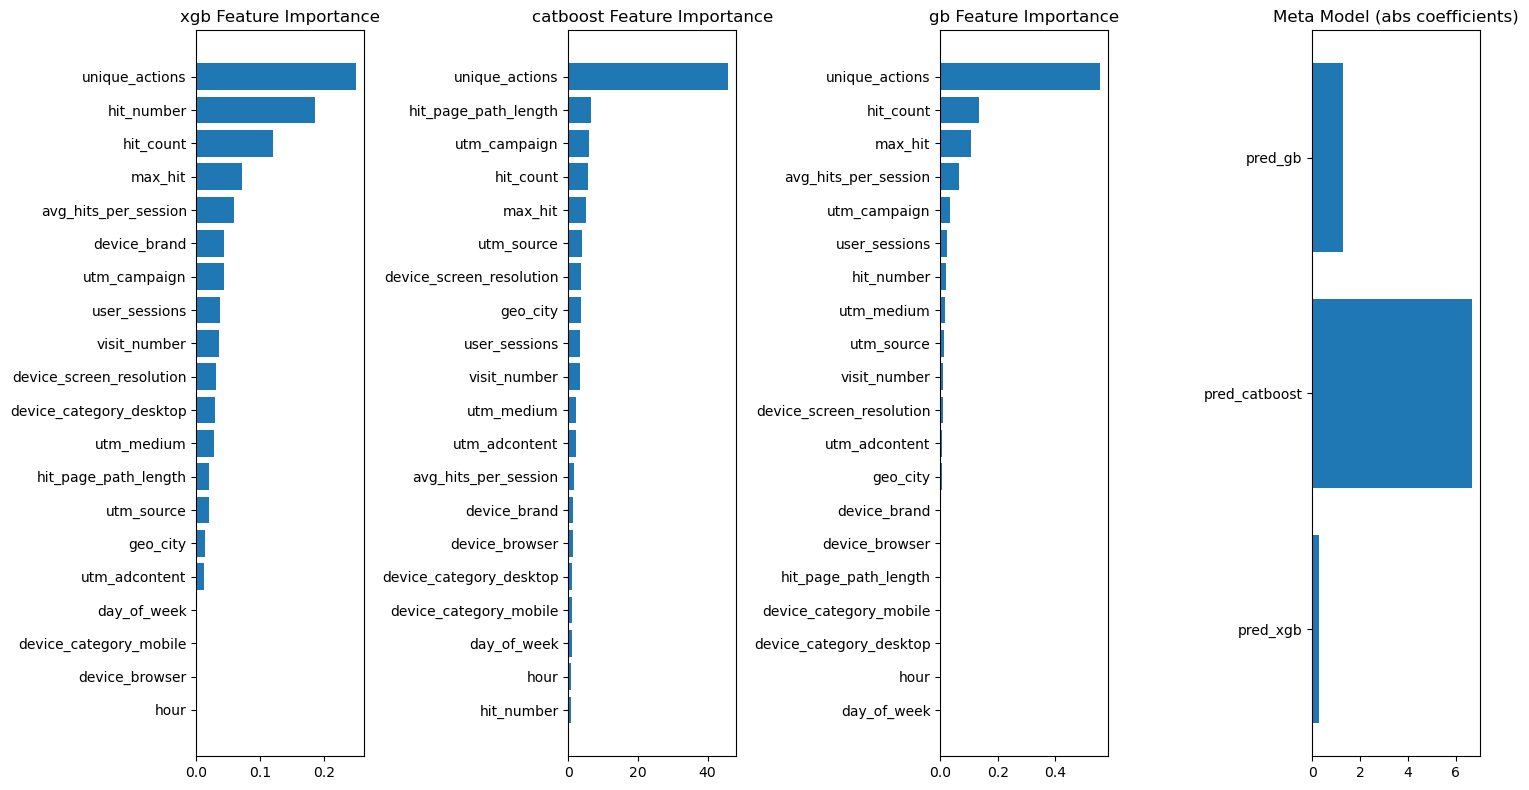


Checking for potential data leaks:
  - Features with zero importance in at least one model: ['device_category_tablet', 'day_of_week', 'hour', 'device_category_mobile', 'device_browser']


[I 2025-05-06 14:02:50,468] Trial 5 finished with value: 0.8838219104319197 and parameters: {'xgb_n_estimators': 154, 'xgb_max_depth': 3, 'xgb_lr': 0.015033346993841165, 'xgb_min_child_weight': 4.038536542632651, 'xgb_gamma': 4.714548519562596, 'xgb_subsample': 0.6616014660103776, 'xgb_colsample_bytree': 0.7593953108716831, 'xgb_alpha': 0.004208735868263724, 'xgb_lambda': 8.110298132030929e-06, 'catboost_iter': 293, 'catboost_depth': 10, 'catboost_lr': 0.023545774516299134, 'cb_l2_leaf_reg': 5.475236553031469, 'cb_border_count': 99, 'cb_random_strength': 2.9199208943369297, 'cb_bagging_temperature': 0.036886947354532795, 'cb_min_data_in_leaf': 31, 'gb_n_estimators': 176, 'gb_max_depth': 2, 'gb_learning_rate': 0.025798509464504106, 'gb_min_samples_split': 19, 'gb_min_samples_leaf': 5, 'gb_max_features': 0.2304053848821008, 'gb_subsample': 0.7447263801387816, 'meta_C': 9.056311714376344, 'meta_max_iter': 863}. Best is trial 2 with value: 0.8890063960237878.


|     5 | 0.883822 |


[I 2025-05-06 14:41:27,261] Trial 6 finished with value: 0.8844806072139297 and parameters: {'xgb_n_estimators': 218, 'xgb_max_depth': 8, 'xgb_lr': 0.02243982507529705, 'xgb_min_child_weight': 7.553947137506736, 'xgb_gamma': 1.838915663596266, 'xgb_subsample': 0.8161529152967897, 'xgb_colsample_bytree': 0.8167648553804474, 'xgb_alpha': 0.00019328469778518898, 'xgb_lambda': 5.276162470390128e-08, 'catboost_iter': 259, 'catboost_depth': 4, 'catboost_lr': 0.01885864373172233, 'cb_l2_leaf_reg': 1.3669762739928752, 'cb_border_count': 164, 'cb_random_strength': 6.807887182238596, 'cb_bagging_temperature': 0.016587828927856152, 'cb_min_data_in_leaf': 26, 'gb_n_estimators': 106, 'gb_max_depth': 7, 'gb_learning_rate': 0.01809507378721579, 'gb_min_samples_split': 15, 'gb_min_samples_leaf': 8, 'gb_max_features': 0.9430569898630611, 'gb_subsample': 0.5687604720729966, 'meta_C': 0.10548702714918053, 'meta_max_iter': 670}. Best is trial 2 with value: 0.8890063960237878.


|     6 | 0.884481 |


[I 2025-05-06 15:46:00,872] Trial 7 finished with value: 0.8877309847444799 and parameters: {'xgb_n_estimators': 282, 'xgb_max_depth': 9, 'xgb_lr': 0.024044240360019044, 'xgb_min_child_weight': 6.939856414307611, 'xgb_gamma': 4.0861110010060795, 'xgb_subsample': 0.7776004057997312, 'xgb_colsample_bytree': 0.7648252891780032, 'xgb_alpha': 8.606336591203087e-07, 'xgb_lambda': 5.556766432156757e-08, 'catboost_iter': 275, 'catboost_depth': 10, 'catboost_lr': 0.0861326122761509, 'cb_l2_leaf_reg': 4.051268119438307, 'cb_border_count': 110, 'cb_random_strength': 7.286961220815369, 'cb_bagging_temperature': 0.8971102599525771, 'cb_min_data_in_leaf': 45, 'gb_n_estimators': 245, 'gb_max_depth': 7, 'gb_learning_rate': 0.013313275850595153, 'gb_min_samples_split': 5, 'gb_min_samples_leaf': 18, 'gb_max_features': 0.6457861536936309, 'gb_subsample': 0.5045985258083148, 'meta_C': 0.020156477059365012, 'meta_max_iter': 1495}. Best is trial 2 with value: 0.8890063960237878.


|     7 | 0.887731 |


[I 2025-05-06 16:50:05,210] Trial 8 finished with value: 0.8868521031771766 and parameters: {'xgb_n_estimators': 51, 'xgb_max_depth': 3, 'xgb_lr': 0.064646697464924, 'xgb_min_child_weight': 7.227056779234239, 'xgb_gamma': 3.259806297513003, 'xgb_subsample': 0.61213465473028, 'xgb_colsample_bytree': 0.8560896106737679, 'xgb_alpha': 7.906653376497142e-07, 'xgb_lambda': 4.010491362023556e-06, 'catboost_iter': 237, 'catboost_depth': 7, 'catboost_lr': 0.17964120089624855, 'cb_l2_leaf_reg': 6.91851603070309, 'cb_border_count': 159, 'cb_random_strength': 1.0273802014981155, 'cb_bagging_temperature': 0.3677158030594335, 'cb_min_data_in_leaf': 14, 'gb_n_estimators': 111, 'gb_max_depth': 10, 'gb_learning_rate': 0.038076147829554464, 'gb_min_samples_split': 18, 'gb_min_samples_leaf': 13, 'gb_max_features': 0.8153301731874836, 'gb_subsample': 0.751318546552596, 'meta_C': 0.5379125214937587, 'meta_max_iter': 1239}. Best is trial 2 with value: 0.8890063960237878.


|     8 | 0.886852 |


In [ ]:
def objective(trial):
    """Функция для оптимизации гиперпараметров с помощью Optuna
    
    Параметры:
    ----------
    trial : optuna.Trial
        Объект trial для управления оптимизацией
        
    Возвращает:
    -----------
    roc_auc : float
        Среднее значение ROC-AUC по кросс-валидации
    """
    
    # Определение пространства поиска гиперпараметров для XGBoost
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 300),
        'max_depth': trial.suggest_int('xgb_max_depth', 2, 10),
        'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_float('xgb_min_child_weight', 1, 10),
        'gamma': trial.suggest_float('xgb_gamma', 0, 5),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('xgb_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('xgb_lambda', 1e-8, 1.0, log=True),
        'eval_metric': 'logloss',
        #'use_label_encoder': False,
        'tree_method': 'hist',
        'random_state': 42,
        'n_jobs': 4
    }

    # Определение пространства поиска гиперпараметров для CatBoost
    cb_params = {
        'iterations': trial.suggest_int('catboost_iter', 50, 300),
        'depth': trial.suggest_int('catboost_depth', 2, 10),
        'learning_rate': trial.suggest_float('catboost_lr', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('cb_l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('cb_border_count', 32, 255),
        'random_strength': trial.suggest_float('cb_random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('cb_bagging_temperature', 0.0, 1.0),
        'min_data_in_leaf': trial.suggest_int('cb_min_data_in_leaf', 1, 50),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'silent': True,
        'thread_count': 4,
        'random_seed': 42
    }

    # Определение пространства поиска гиперпараметров для GradientBoosting
    gb_params = {
        'n_estimators': trial.suggest_int('gb_n_estimators', 50, 300),
        'max_depth': trial.suggest_int('gb_max_depth', 2, 10),
        'learning_rate': trial.suggest_float('gb_learning_rate', 0.01, 0.3, log=True),
        'min_samples_split': trial.suggest_int('gb_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('gb_min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('gb_max_features', 0.1, 1.0),
        'subsample': trial.suggest_float('gb_subsample', 0.5, 1.0),
        'random_state': 42
    }

    # Гиперпараметры для мета-модели (LogisticRegression)
    lr_params = {
        'C': trial.suggest_float('meta_C', 0.01, 10, log=True),
        'max_iter': trial.suggest_int('meta_max_iter', 500, 2000),
        'penalty': 'l2',
        'solver': 'lbfgs',
        'random_state': 42
    }
    
    # Создание моделей с предложенными гиперпараметрами
    xgb = XGBClassifier(**xgb_params)
    catboost = CatBoostClassifier(**cb_params)
    gb = GradientBoostingClassifier(**gb_params)
    meta = LogisticRegression(**lr_params)
    
    # Создание стекинг-ансамбля
    model = StackingClassifier(
        estimators=[
            ('xgb', xgb),
            ('catboost', catboost),
            ('gb', gb)
        ],
        final_estimator=meta,
        stack_method='auto',
        passthrough=False,
        n_jobs=-1
    )
    
    # Оценка модели с помощью кросс-валидации
    roc_auc = cross_val_score(
        model,
        X_processed,
        y_processed,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    ).mean()
    
    
    # Периодическая проверка важности признаков для выявления утечек
    if trial.number % 5 == 0:  # Проверяем каждые 5 trials
        model.fit(X_processed, y_processed)
        check_feature_importance(model, X_processed.columns, X_processed, y_processed)
    
    return roc_auc

def check_feature_importance(model, feature_names, X_processed, y_processed):
    """Проверка важности признаков для выявления потенциальных утечек данных
    
    Параметры:
    ----------
    model : estimator
        Обученная модель
    feature_names : list
        Список имен признаков
    X_processed : DataFrame
        Обработанные признаки
    y_processed : array-like
        Целевая переменная
    """
    plt.figure(figsize=(12, 8))
    
    # Подготовка subplots для визуализации
    num_models = len(model.named_estimators_) + (1 if hasattr(model.final_estimator_, 'coef_') else 0)
    fig, axes = plt.subplots(1, num_models, figsize=(15, 8))
    if num_models == 1:
        axes = [axes]
    
    current_ax = 0
    
    # Визуализация важности признаков для базовых моделей
    for name, estimator in model.named_estimators_.items():
        try:
            importances = estimator.feature_importances_
            sorted_idx = np.argsort(importances)
            axes[current_ax].barh(np.array(feature_names)[sorted_idx[-20:]], importances[sorted_idx[-20:]])
            axes[current_ax].set_title(f"{name} Feature Importance")
            current_ax += 1
        except AttributeError:
            continue
    
    # Визуализация коэффициентов мета-модели
    if hasattr(model.final_estimator_, 'coef_'):
        coef = model.final_estimator_.coef_[0]
        predictor_names = [f'pred_{name}' for name in model.named_estimators_]
        sorted_idx = np.argsort(np.abs(coef))
        
        axes[current_ax].barh(np.array(predictor_names), np.abs(coef))
        axes[current_ax].set_title("Meta Model (abs coefficients)")
    
    plt.tight_layout()
    plt.show()
    
    # Проверка на потенциальные утечки данных
    print("\nChecking for potential data leaks:")
    
    # Поиск подозрительных признаков по названию
    leaky_candidates = [col for col in feature_names 
                       if ('date' in col.lower() or 
                           'time' in col.lower() or 
                           'id' in col.lower() or
                           'target' in col.lower())]
    if leaky_candidates:
        print(f"  - Found potential leaky features: {leaky_candidates}")
    
    # Поиск признаков с нулевой важностью
    zero_importance_features = set()
    for name, estimator in model.named_estimators_.items():
        try:
            importances = estimator.feature_importances_
            zero_importance = [col for col, imp in zip(feature_names, importances) if imp == 0]
            zero_importance_features.update(zero_importance)
        except AttributeError:
            continue
    
    if zero_importance_features:
        print(f"  - Features with zero importance in at least one model: {list(zero_importance_features)[:10]}")
    
    # Проверка корреляции с целевой переменной
    try:
        if isinstance(X_processed, pd.DataFrame):
            corr = X_processed.corrwith(y_processed).abs()
            high_corr = corr[corr > 0.8].index.tolist()
            if high_corr:
                print(f"  - Features with high correlation to target (>0.8): {high_corr}")
                
                # Проверка стабильности важности признаков
                try:
                    result = permutation_importance(
                        model, X_processed, y_processed, n_repeats=5, random_state=42
                    )
                    high_importance_diff = [
                        feature_names[i] for i in np.where(
                            (result.importances_mean > 0.1) & 
                            (result.importances_std > result.importances_mean)
                        )[0]
                    ]
                    if high_importance_diff:
                        print(f"  - Features with unstable importance (possible leak): {high_importance_diff}")
                except:
                    pass
    except Exception as e:
        print(f"  - Correlation check failed: {str(e)}")

# Настройка исследования Optuna
study = optuna.create_study(
    direction='maximize',  # Максимизируем ROC-AUC
    sampler=TPESampler(seed=42),  # Используем TPE sampler
    pruner=MedianPruner(n_warmup_steps=5)  # Прунер для досрочного прекращения неудачных trials
)

def log_trial_progress(study, trial):
    """Callback для логирования прогресса оптимизации"""
    if trial.number == 0:
        print("| Trial | ROC-AUC  |")
        print("|-------|----------|")
    value = trial.value if trial.value is not None and trial.value != float('-inf') else 0.0
    print(f"| {trial.number:5} | {value:.6f} |")

# Запуск оптимизации
try:
    print("Starting optimization...")
    study.optimize(
        objective,
        n_trials=10,  # Количество trials
        callbacks=[log_trial_progress],  # Callback для логирования
        gc_after_trial=True  # Сборка мусора после каждого trial
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

# Анализ результатов
if len(study.trials) > 0:
    print("\nBest trial:")
    print(f"  ROC-AUC: {study.best_value:.6f}")
    #print(f"  PR-AUC: {study.best_trial.user_attrs['pr_auc']:.6f}")
    print("\nBest params:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    # Создание финального ансамбля с лучшими параметрами
    best_params = study.best_params
    
    # Извлечение параметров для каждого алгоритма
    cb_params = {k[3:]: v for k, v in best_params.items() if k.startswith('cb_')}
    xgb_params = {k[4:]: v for k, v in best_params.items() if k.startswith('xgb_')}
    gb_params = {k[3:]: v for k, v in best_params.items() if k.startswith('gb_')}
    lr_params = {k[5:]: v for k, v in best_params.items() if k.startswith('meta_')}
    
    # Добавление фиксированных параметров
    cb_params.update({
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 42,
        'thread_count': -1,
        'silent': True
    })
    
    xgb_params.update({
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42,
        'n_jobs': -1
    })
    
    gb_params.update({
        'random_state': 42
    })
    
    lr_params.update({
        'solver': 'saga',
        'random_state': 42,
        'max_iter': 1000
    })
    
    # Создание финального ансамбля
    estimators = [
        ('catboost', CatBoostClassifier(**cb_params)),
        ('xgboost', XGBClassifier(**xgb_params)),
        ('gb', GradientBoostingClassifier(**gb_params))
    ]
    
    meta_model = LogisticRegression(**lr_params)
    final_ensemble = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model,
        cv=5,
        stack_method='predict_proba',
        n_jobs=-1
    )
    
    # Создание полного pipeline
    best_pipeline = ImbPipeline([
        # Здесь могут быть этапы предобработки
        ('ensemble', final_ensemble)
    ])
    
    # Обучение на всех данных
    best_pipeline.fit(X_processed, y_processed)
    
    # Проверка важности признаков финальной модели
    print("\nFinal model feature importance check:")
    check_feature_importance(final_ensemble, X_processed.columns, X_processed, y_processed)
    
    # Функция для предсказаний
    def predict_proba(X_new):
        """Предсказание вероятностей с помощью финальной модели
        
        Параметры:
        ----------
        X_new : DataFrame
            Новые данные для предсказания
            
        Возвращает:
        -----------
        proba : array-like или None
            Массив предсказанных вероятностей или None в случае ошибки
        """
        try:
            return best_pipeline.predict_proba(X_new)
        except Exception as e:
            print(f"Prediction error: {str(e)}")
            return None
else:
    print("No completed trials!")

In [ ]:
# Получаем важность фичей из всех базовых моделей
feature_importances = {}

for name, estimator in final_ensemble.named_estimators_.items():
    try:
        importances = estimator.feature_importances_
        feature_importances[name] = pd.Series(importances, index=X_processed.columns)
    except AttributeError:
        continue

# Создаем DataFrame с важностью фичей
importance_df = pd.DataFrame(feature_importances)
importance_df['mean_importance'] = importance_df.mean(axis=1)

# Выбираем топ-N самых важных фичей
top_n = 5 
significant_features = importance_df.nlargest(top_n, 'mean_importance').index.tolist()
print(f"Топ-{top_n} самых важных фичей:")
print(importance_df.head(top_n))

In [ ]:
# Обновляем numeric_features, оставляя только значимые
numeric_features = [f for f in numeric_features if f in significant_features]
category_features = [f for f in category_features if f in significant_features]
# Обновляем preprocessor

# Создаем preprocessor с правильными именами признаков

preprocessor = ColumnTransformer(
    
    transformers=[
        ('num', ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('encode_utm', SafeCatBoostEncoder(cols=category_features), 
         category_features),
        ('hit_path', ImbPipeline([
            ('transformer', HitPagePathTransformer()),
            ('scaler', StandardScaler())
        ]), other_numeric_features),
        ('cat_onehot', ImbPipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), other_category_features)      
        
        ],
    remainder='drop',
    verbose_feature_names_out=False
    
)

# Создаем финальный пайплайн (без семплирования)
final_deploy_pipeline = ImbPipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),  # Только предобработка
    ('ensemble', final_ensemble)           # Ансамбль
])

# Обучение (на несбалансированных данных)
final_deploy_pipeline.fit(X, y)

In [ ]:
# Получаем предсказанные вероятности для положительного класса (класс 1)
# predict_proba возвращает вероятности для каждого класса (например, [0.2, 0.8] - 20% для класса 0, 80% для класса 1)
# [:, 1] выбирает только вероятности для положительного класса (второй столбец)
test_probas = final_deploy_pipeline.predict_proba(X_test)[:, 1] 

# Получаем "жесткие" предсказания классов (0 или 1)
# По умолчанию используется порог 0.5: если вероятность > 0.5, то предсказывается класс 1, иначе 0
test_preds = final_deploy_pipeline.predict(X_test)

In [ ]:
# Оцениваем качество
print(f"Test ROC-AUC: {roc_auc_score(y_test, test_probas):.4f}")
precision, recall, _ = precision_recall_curve(y_test, test_probas)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, test_preds))
print("\nConfusion Matrix:") 
print(confusion_matrix(y_test, test_preds))

#### Подготовка итоговой модели к deploy


In [ ]:
# Определение кастомных трансформеров
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Трансформер для создания новых фич из сырых данных визитов.
    Создает временные, сессионные и пользовательские характеристики.
    """

    def __init__(self, verbose=True):
        self.verbose = verbose  # Флаг для отладочного вывода
        self.feature_names_out_ = None  # Для совместимости с sklearn

    def fit(self, df, y=None):
        """Не требует обучения, только для совместимости с sklearn API"""
        if self.verbose:
            print("\n[FeatureEngineer] FIT: Инициализация трансформера")
            print(f"Получено {len(df)} строк для анализа")
        return self

    def transform(self, df):
        """Основной метод преобразования данных"""
        if self.verbose:
            print("\n[FeatureEngineer] TRANSFORM: Начало обработки")
            print(f"Входные данные: {len(df)} строк, {len(df.columns)} колонок")
            print("Первые 5 строк входных данных:")
            print(df.head())

        # 1. Преобразование даты и времени
        if self.verbose:
            print("\n[1/3] Обработка временных меток...")

        df['visit_datetime'] = pd.to_datetime(df['visit_date'] + ' ' + df['visit_time'])
        df['hour'] = df['visit_datetime'].dt.hour
        df['day_of_week'] = df['visit_datetime'].dt.dayofweek

        if self.verbose:
            print("Созданы фичи:")
            print("- visit_datetime (объединенная дата-время)")
            print("- hour (час визита)")
            print("- day_of_week (день недели)")
            print("Пример преобразованных данных:")
            print(df[['visit_date', 'visit_time', 'visit_datetime', 'hour', 'day_of_week']].head())

        # 2. Статистика по сессиям
        if self.verbose:
            print("\n[2/3] Расчет сессионной статистики...")

        session_stats = (
            df.groupby('session_id')
            .agg(
                hit_count=('hit_number', 'count'),
                max_hit=('hit_number', 'max'),
                unique_actions=('event_action', 'nunique')
            )
            .reset_index()
        )

        if self.verbose:
            print("Рассчитаны сессионные метрики:")
            print("- hit_count (количество хитов в сессии)")
            print("- max_hit (максимальный номер хита)")
            print("- unique_actions (уникальные действия)")
            print("Пример сессионной статистики:")
            print(session_stats.head())

        # 3. Статистика по пользователям
        if self.verbose:
            print("\n[3/3] Расчет пользовательской статистики...")

        user_stats = (
            df.groupby('client_id')
            .agg(
                user_sessions=('session_id', 'nunique'),
                avg_hits_per_session=('hit_number', 'mean')
            )
            .reset_index()
        )

        if self.verbose:
            print("Рассчитаны пользовательские метрики:")
            print("- user_sessions (количество сессий пользователя)")
            print("- avg_hits_per_session (среднее число хитов на сессию)")
            print("Пример пользовательской статистики:")
            print(user_stats.head())

        # 4. Объединение всех данных
        if self.verbose:
            print("\nОбъединение всех данных...")

        result_df = (
            df
            .merge(session_stats, on='session_id', how='left')
            .merge(user_stats, on='client_id', how='left')
        )

        if self.verbose:
            print("\n[FeatureEngineer] Преобразование завершено")
            print(f"Итоговый DataFrame: {len(result_df)} строк, {len(result_df.columns)} колонок")
            print("Новые колонки в данных:")
            new_cols = set(result_df.columns) - set(df.columns)
            print(list(new_cols))
            print("\nПример итоговых данных:")
            print(result_df.head())

        return result_df

    def get_feature_names_out(self, input_features=None):
        """Возвращает имена выходных фич для совместимости с sklearn"""
        if self.verbose:
            print("\n[FeatureEngineer] Запрос имен выходных фич")
        return np.array(list(self.feature_names_out_)) if self.feature_names_out_ else None

class HitPagePathTransformer(BaseEstimator, TransformerMixin):
    """Трансформер для преобразования URL пути в числовую фичу - длину пути.
    Обрабатывает пути вида '/path/to/page?param=value', извлекая количество элементов пути.
    """

    def __init__(self, verbose=True):
        self.feature_names_out_ = ['hit_page_path_length']  # Название выходной фичи
        self.verbose = verbose  # Флаг отладочного вывода
        self.feature_names_in_ = None  # Сохраняет имена входных фич при обучении

    def fit(self, X, y=None):
        """Сохраняет имена фич для pandas DataFrame (если есть)"""
        if self.verbose:
            print("\n=== FIT ===")
            print(f"Входные данные типа: {type(X)}")

        if hasattr(X, 'columns'):
            self.feature_names_in_ = X.columns.tolist()
            if self.verbose:
                print(f"Обнаружены колонки: {self.feature_names_in_}")
                print(f"Первые 5 строк входных данных:\n{X.head()}")

        if self.verbose:
            print(f"Выходные фичи будут: {self.feature_names_out_}")
        return self

    def transform(self, X):
        """Преобразует путь страницы в длину пути (количество элементов)
        Обрабатывает как DataFrame, так и numpy array.
        Удаляет параметры запроса (все что после ?) перед подсчетом элементов пути.
        """
        if self.verbose:
            print("\n=== TRANSFORM ===")
            print(f"Тип входных данных: {type(X)}")

        def path_corrector(x):
            """Внутренняя функция обработки одного URL:
            - Обрабатывает NaN значения
            - Удаляет параметры запроса (после ?)
            - Разбивает путь по '/' и считает количество элементов
            """
            if pd.isna(x):
                return 0
            # Разделяем по ? и берем первую часть (путь)
            path_part = str(x).split('?')[0]
            # Разбиваем путь по '/' и фильтруем пустые элементы
            path_elements = [p for p in path_part.split('/') if p]
            return len(path_elements)

        if isinstance(X, pd.DataFrame):
            if self.verbose:
                print(f"Обрабатываю DataFrame с колонками: {X.columns.tolist()}")
                print("Пример данных до преобразования:")
                print(X['hit_page_path'].head())

            result = X.copy()
            result['hit_page_path_length'] = X['hit_page_path'].apply(path_corrector)
            result = result.drop(columns=['hit_page_path'])

            if self.verbose:
                print("\nРезультат преобразования:")
                print(result.head())
                print(f"Выходные колонки: {result.columns.tolist()}")

            return result

        elif isinstance(X, np.ndarray):
            if self.verbose:
                print(f"Обрабатываю numpy array с формой: {X.shape}")
                print(f"Первые 5 значений:\n{X[:5]}")

            result = np.array([[path_corrector(x)] for x in X])

            if self.verbose:
                print("\nРезультат преобразования:")
                print(f"Первые 5 значений:\n{result[:5]}")

            return result

        else:
            raise TypeError(f"Неподдерживаемый тип данных: {type(X)}")

    def get_feature_names_out(self, input_features=None):
        """Возвращает имена выходных фич (совместимость с sklearn ColumnTransformer)"""
        check_is_fitted(self, 'feature_names_out_')
        if self.verbose:
            print("\n=== GET_FEATURE_NAMES_OUT ===")
            print(f"Возвращаемые фичи: {self.feature_names_out_}")
        return np.array(self.feature_names_out_)

class SafeCatBoostEncoder(BaseEstimator, TransformerMixin):
    """Безопасный CatBoostEncoder с обработкой пропущенных значений и проверкой входных данных.

    Особенности:
    - Автоматически заполняет пропуски указанным значением (по умолчанию 'unknown')
    - Проверяет наличие всех указанных колонок
    - Сохраняет имена фич для совместимости с sklearn Pipeline
    - Подробное логирование процесса при verbose=True
    """

    def __init__(self, cols, fill_value='unknown', verbose=True):
        """
        Инициализация кодировщика.

        Параметры:
        ----------
        cols : str или list
            Колонки для кодирования
        fill_value : str, optional
            Значение для заполнения пропусков (по умолчанию 'unknown')
        verbose : bool, optional
            Флаг подробного вывода (по умолчанию True)
        """

        self.cols = cols if isinstance(cols, list) else [cols]  # Всегда работаем с list
        self.fill_value = fill_value
        self.encoder = None  # Будет инициализирован при обучении
        self.feature_names_in_ = None  # Сохранит имена входных фич
        self.verbose = verbose

    def fit(self, X, y):
        """Обучение кодировщика на данных.

        Этапы:
        1. Проверка и преобразование входных данных
        2. Заполнение пропусков
        3. Обучение CatBoostEncoder
        """
        # Шаг 1: Преобразование в DataFrame и сохранение имен фич
        X = pd.DataFrame(X)
        self.feature_names_in_ = X.columns.tolist()

        if self.verbose:
            print("\n=== FIT ===")
            print(f"Входные колонки: {self.feature_names_in_}")
            print(f"Колонки для кодирования: {self.cols}")
            print(f"Первые 5 строк до обработки:\n{X[self.cols].head()}")

        # Шаг 2: Проверка наличия всех указанных колонок
        missing = set(self.cols) - set(X.columns)
        if missing:
            raise ValueError(f"Отсутствуют колонки: {missing}")

        # Шаг 3: Заполнение пропусков указанным значением
        X_filled = X[self.cols].fillna(self.fill_value)

        if self.verbose:
            print(f"\nПосле заполнения пропусков ('{self.fill_value}'):\n{X_filled.head()}")

        # Шаг 4: Обучение CatBoostEncoder
        X_filled = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        self.encoder = CatBoostEncoder(cols=self.cols)
        self.encoder.fit(X_filled, y)

        if self.verbose:
            print("\nКодировщик успешно обучен!")
            print(f"Пример закодированных значений (первые 5):")
            encoded_sample = self.encoder.transform(X_filled.head())
            print(encoded_sample.head())

        return self

    def transform(self, X):
        """Применение обученного кодировщика к новым данным.

        Этапы:
        1. Проверка структуры входных данных
        2. Заполнение пропусков
        3. Применение кодирования
        """
        # Шаг 1: Преобразование в DataFrame с проверкой колонок
        X = pd.DataFrame(X, columns=self.feature_names_in_)

        if self.verbose:
            print("\n=== TRANSFORM ===")
            print(f"Входные колонки: {self.feature_names_in_}")
            print(f"Первые 5 строк до обработки:\n{X[self.cols].head()}")

        # Шаг 2: Заполнение пропусков (для новых данных)
        X[self.cols] = X[self.cols].fillna(self.fill_value)

        if self.verbose:
            print(f"\nПосле заполнения пропусков ('{self.fill_value}'):\n{X[self.cols].head()}")

        # Шаг 3: Применение обученного кодировщика
        X[self.cols] = self.encoder.transform(X[self.cols])

        if self.verbose:
            print("\nПосле кодирования CatBoostEncoder:")
            print(X[self.cols].head())

        return X

    def get_feature_names_out(self, input_features=None):
        """Возвращает имена фичей после преобразования.

        Для CatBoostEncoder имена фичей не меняются - исходные категориальные колонки
        заменяются на числовые значения с теми же именами.
        """
        check_is_fitted(self, 'feature_names_in_')
        if input_features is not None:
            # Проверяем соответствие переданных имен обученным
            if len(input_features) != len(self.feature_names_in_):
                raise ValueError("Несоответствие числа фичей.")
            return np.array(input_features)
        return np.array(self.feature_names_in_)


# Определение списков фичей
numeric_features = [f for f in numeric_features if f in significant_features]
category_features = [f for f in category_features if f in significant_features]
other_category_features = ['device_category']
other_numeric_features = ['hit_page_path']

# Создание препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('encode_utm', SafeCatBoostEncoder(cols=category_features), category_features),
        ('hit_path', Pipeline([
            ('transformer', HitPagePathTransformer()),
            ('scaler', StandardScaler())
        ]), other_numeric_features),
        ('cat_onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), other_category_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# Создание финального пайплайна
final_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer(verbose=False)),
    ('preprocessor', preprocessor),
    ('ensemble', create_final_ensemble())
])

# Функция для обучения и сохранения пайплайна
def train_and_save_pipeline(X_train, y_train, save_path='final_conversion_pipeline_lead.pkl'):
    """
    Обучает и сохраняет пайплайн

    Параметры:
    ----------
    X_train : DataFrame
        Обучающие данные
    y_train : array-like
        Целевая переменная
    save_path : str, optional
        Путь для сохранения пайплайна (по умолчанию 'final_conversion_pipeline_lead.pkl')
    """
    print("Обучение пайплайна...")
    final_pipeline.fit(X_train, y_train)

    print("Сохранение пайплайна...")
    joblib.dump(final_pipeline, save_path)
    print(f"Пайплайн успешно сохранен в {save_path}")

In [ ]:
# Обучаем и сохраняем пайплайн

sessions_with_target = sessions_with_target.replace(['(not set)', '(none)'], np.nan)
sessions_with_target['target'] = sessions_with_target['target'].fillna(0)

y = sessions_with_target['target'].reset_index(drop=True)
X = sessions_with_target.drop(columns = ['target']).reset_index(drop=True)
train_and_save_pipeline(X, y, save_path='final_conversion_pipeline_lead.pkl')